<a href="https://colab.research.google.com/github/DaveMSU/Kaggle/blob/master/M5_Forecasting/Solution(rus).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#***1 этап. Подключение библиотек и загрузка датасетов с диска:***


In [1]:
# Библиотеки:
# Таблицами и массивы:
import torch
import numpy as np
import pandas as pd
import scipy.stats as stats # Для 5-го этапа.

# Фиксации seed'ов и более удобного вывода:
import random
import time
from tqdm import tqdm_notebook as tqdm

# Для форматирования таблиц в более естественный вид:
from datetime import date, timedelta

# Для 4 этапа - визуализации данных:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# Для декомпзиции временных рядов:
import statsmodels.api as sm
from pandas.core.nanops import nanmean as pd_nanmean #  Вычисляет ср-ее, игнорируя np.nan.
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

# Фуксируем seed:
seed_num = 1

random.seed(seed_num)
np.random.seed(seed_num)

# Отключаем предупреждения:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Доступ к диску:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

#***2 этап. Первичный анализ данных:***


***Описание данных и цель соревнования:***

*Будем анализировать данные предоставленные знаменитой в США сетью магазинов Walmart, в рамках парного Kaggle соревнования*

https://www.kaggle.com/c/m5-forecasting-accuracy

https://www.kaggle.com/c/m5-forecasting-uncertainty

*По условию соревнования для каждого товара требуется сделать точное предсказание кол-ва проданных экземпляров за последующие 28 дней и предсказать некоторые статистики (квантильные уровни, в том числе медиану) еще за следующие 28 дней. Всё это основываясь на предыдущих данных, собранных за период 2011 - 2016гг (1913 дней), т.о. требуется сделать прогноз на 8 недель.*

*В связи с неоднородностью задания, решено было сделать два соревнования, использующие одни и те же датасеты, но требующий от участников разных целей.*

В качестве метрики для 1-го задания было выбрано взвешенное RMSSE (скорректированное RMSE, будет описана ниже).

Больший вес получают ошибки, посчитанные на более дорогих товарах.



**Данные имеют иерархическую структуру:**
1.    Информация предоставляется сетью магазинов Walmart:
2.    Рассматриваются данные собранные по 3-ем штатам - Калифорния, Техас и Висконсин.
3.  В каждом штате данные собраны из суммарно из 10 магазинов - точек (см. дерево).
4.  В каждом магазине товары можно разбить на большие категории - товары для дома, еда, товары для хобби.
5.  Каждая категория товаров, может делить на субкатегории - [дом1, дом2], [еда1, еда2, еда3], [хобби1, хобби2] (далее, употребляя слово "субкатегория", мы будем иметь ввиду именно этот уровень иерархии товаров).
6.  В таблице sales хранятся идентификаторы всех товаров с указанием воложения в этой иерархии - т.е. точное указания о принадлежности штату, магазину, подкатегории.
7.  Всего 3049 уникльных видов товаров, имеющиеся в 10 разных магазинах по 3 штатам и того 30490 уникальных позиций, поштучные продажи которых и нужно исследовать и спрогнозировать.

*(ниже см. иллюстрацию)*

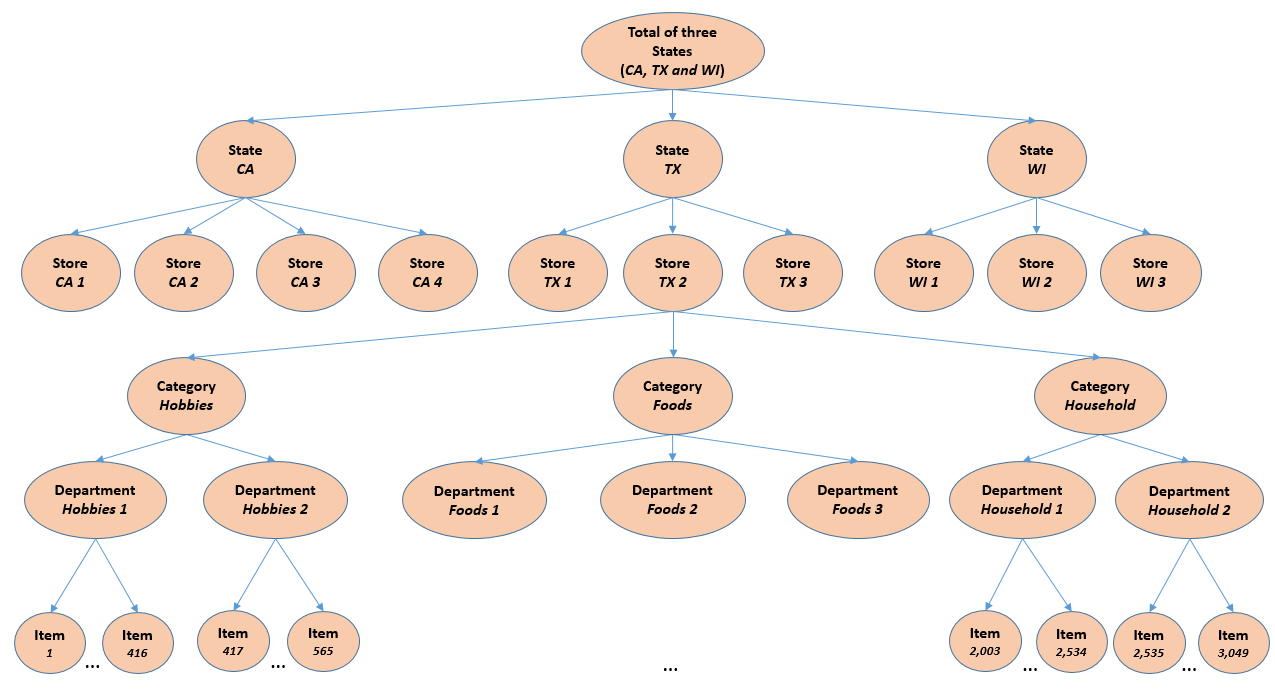

  **Walmart предоставляет 3 таблицы с данными:**

calendar.csv - содержит информацию о датах, в которые были совершены продажи.

sales_train_validation - содержит информацию о поштучных продажах по товарам и по магазинам. Всего 30490 товаров, для которых предоставлены соотвествующие кол-ва поштучных продаж за период в 1913 дней, и соответствующие данные которых нужно предсказать на 8 недель вперед.

sell_prices - содержит информацию о цене проданных товаров по магазинам и по датам.

*(подробнее см. ниже)*

In [6]:
calen_df = pd.read_csv('C:/Users/Professional/Desktop/Kaggle-master/calendar.csv')
sales_df = pd.read_csv('C:/Users/Professional/Desktop/Kaggle-master/sales_train_validation.csv')
price_df = pd.read_csv('C:/Users/Professional/Desktop/Kaggle-master/sell_prices.csv')

#pd.options.display.max_rows = 1000 # Увеличиваем максимальное кол-во строк, чтобы лучше посмотреть на датасет.

Датасеты представляют из себя следующии таблицы с полями:

***calen_df (calendar.csv)***

*    *date: Дата в формате “y-m-d”.*
*    *wm_yr_wk: Номер недели, на которую выпадает дата.*
*    *weekday: Тип дня недели (Saturday, Sunday, …, Friday).*
*    *wday: Номер дня недели, начиная с субботы(Saturday).*
*    *month: Номер месяца, на которую выпадет дата.*
*    *year: Год, на который выпадает дата.*
*    *event_name_1: Если на дату выпало какое-то знаменательное событие, то тут содержится названия этого события, иначе NaN.*
*    *event_type_1: Если на дату выпало какое-то знаменательное событие, то тут содержится тип этого события, иначе NaN.*
*    *event_name_2: Если на дату выпало какое-то еще одно знаменательное событие, то тут содержится названия второго события, иначе NaN.*
*    *event_type_2: Если на дату выпало какое-то еще одно знаменательное событие, то тут содержится тип второго события, иначе NaN.*
*    *snap_CA, snap_TX, and snap_WI: Бинарное значение (**0** или **1**), которое говорит, произошла ли выплата в конкретно штате пособия 1/10 населения или нет. **1** показывает, что выплаты были произведены. (всего в рамках 1 месяца наблюдается ровно 10 единиц, см. ниже)*

*SNAP - Supplemental Nutrition Assistance Program / Программа Помощи в Дополнительном Питании. Правительство США предоставлет малообеспеченным семьям пластиковую карту, во многих штатах денежные пособия на которые распределяются между людьми в течение 10 дней месяца, и в каждый из этих дней 1/10 населения получает пособие по своей карточке. В основном карточкой можно оплачивать здоровые продукты питания такие как фрукты, мясо, молоко и т.д. Действие карты не распростроняется на такие товары как алкоголь, сигареты, корма для животных, фастфуда т.о. в том числе и принадлежностей для дома и товаров для хобби тоже.
Подробней можно ознакомится тут: [link text](https://www.fns.usda.gov/snap/supplemental-nutrition-assistance-program)

In [7]:
calen_df

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


***sales_df (sales_train_validation)***

*    *id: Идентификатор конкретного товара, анализируя данные о котором и нужно сделать прогноз на 8 недель.*
*    *item_id: Идентификатор товара.*
*    *dept_id: Идентификатор категории, которой принадлежит объект (товары для доам, еда или товары для хобби).*
*    *cat_id: Идентификатор категории, которой принадлежит объект (товары для доам, еда или товары для хобби).*
*    *store_id: Идентификатор магазина в котором товар был продан.*

In [8]:
sales_df

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


***price_df (sell_price)***


*    *store_id: Идентификатор магазина (содержащий метку штата) , в котором был продан товар.* 
*    *item_id: Идентификатор товара.*
*    *wm_yr_wk: Номер недели.*
*    *sell_price: Цена товара за данную неделю в данном магазине. Цена указана за неделю (в среднем за семь дней). Если цена отсутствует для некоторой недели, о это говорит о том, что за данную неделю не было продано ниодного товара. Стоит обратить внимание, что хотя цены являются постоянными на еженедельной основе, они могут меняться с течением времени (как на train'е, так и на test'е).*

Отметим сразу следующее:
*    Очень маленькое стандартное отклонение, и оно, вообще говоря, кажется естественным, ведь цена в среднем на продукт постоянная, но все-таки видимо изменчива посредством некоторых событий.

In [12]:
(price_df)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


***Ход исследования и анализа данных:***
3.    **Предобработка данных:** *сформируем различные датафреймы, чтобы получить нужные агрегации данных, которые мы будем затем использовать в следующих этапах.*

4.    **Визуальный анализ данных:** *используя датафреймы, сформированные на прошлом шаге, построим следующие визуализации:*
    *    Рассмотрим гистограммы распределений различных перцентилей, распределений перцентилей, агрегированных по категориям товаров, скатер плоты для анализа уровня их корреляций.
    *    Рассмотрим графики изменения различных средних величин по дням, также в различной комбинации агрегирования.
    *    Посмотрим на различные статистики уже по субкатегориям товаров, агрегированные по событиям (event_type_1).

5.    **Проверка статистических гипотез:** *прорять будем следующий гипотезы: (более формальные формулировки см. в соотв. вкладке.)*

    *    Товары субкатегории FOODS_3 во всех штатах покупают одинаково часто.    
    *    Дешевые товары покупают так же часто как и дорогие.
    *    SNAP льготы не влияют на спрос продуктов категории FOODS.
    *    Товары всех субкатегорий одинаково часто покупают.

6.    **Предсказания временного ряда и отправка решения на Kaggle:** *препарируем данные, напишим простой baseline и попробуем написать сложную модель и сравним результаты.*

#***3 Этап. Предобработка данных:***

**main_df:**

*Датасет, в котором хранится кол-во продаж для каждого товара за последнии 1913 дней, с дополнительной информацией о типе события и 3-ёх snap флагов. Теперь данные имеют более репрезентативный вид.*

**id_dict:**

*В связи с тем, что название столбцов теперь очень грамоздкие, переименуем их в более компактный вид и запомним исходные названия в словаре, тогда при необходимости мы можем быстро перейти к соответствующим начальным названиям.*

**name_id:**

*Словарь аналогичный id_dict, но где ключи и значения переставлены.*

In [0]:
main_df = sales_df.drop(['item_id','dept_id','cat_id','store_id','state_id'], axis=1) # Убираем лишнии стобцы.
main_df = main_df.rename({'id': 'date'}, axis=1).set_index('date').T                  # Теперь индексы
main_df.index = [date(2011,1,29) + timedelta(delta) for delta in range(1913)]         #  строк - даты, а столбцов
main_df.columns = list(map(lambda line: line[:-11], main_df.columns))                 #  id название товаров. 
id_dict = {prev_name: "_" + str(new_name) for new_name, prev_name in enumerate(main_df.columns)} # Переименнуем стобцы, но
name_id = dict(reversed(item) for item in id_dict.items())                                       #  сохраним старые название в виде двух словарей, чтобы 
main_df.columns = id_dict.values()                                                               #   было возможно переходить от id к названиям и от названий к id.

In [0]:
right = main_df.reset_index()
left = calen_df.drop(['wm_yr_wk','weekday','wday',\
               'month','year','d','event_name_1',\
               'event_name_2','event_type_2'], axis=1)
main_df = left.join(right, rsuffix='date').dropna(thresh=10).drop(['index'], axis=1).rename({'event_type_1': 'event'}).set_index('date')

In [10]:
main_df.iloc[[0,1,500,-1]]

,event_type_1,snap_CA,snap_TX,snap_WI,_0,_1,_2,_3,_4,_5,_6,_7,_8,_9,_10,_11,_12,_13,_14,_15,_16,_17,_18,_19,_20,_21,_22,_23,_24,_25,_26,_27,_28,_29,_30,_31,_32,_33,_34,_35,...,_30450,_30451,_30452,_30453,_30454,_30455,_30456,_30457,_30458,_30459,_30460,_30461,_30462,_30463,_30464,_30465,_30466,_30467,_30468,_30469,_30470,_30471,_30472,_30473,_30474,_30475,_30476,_30477,_30478,_30479,_30480,_30481,_30482,_30483,_30484,_30485,_30486,_30487,_30488,_30489
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-29,NaN,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,9.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,16.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,14.0,0.0,0.0,7.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
2011-01-30,NaN,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,12.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.0,0.0,0.0,7.0,0.0,0.0,6.0,13.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,11.0,1.0,0.0,4.0,0.0,0.0,6.0,0.0,0.0
2012-06-12,Sporting,0,1,1,0.0,0.0,0.0,0.0,2.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0,13.0,2.0,1.0,0.0,9.0,0.0,0.0,13.0,38.0,6.0,0.0,8.0,6.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2016-04-24,NaN,0,0,0,1.0,0.0,1.0,2.0,4.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,4.0,6.0,6.0,0.0,12.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,3.0,11.0,0.0,4.0,0.0,0.0,0.0,2.0,...,4.0,6.0,0.0,0.0,6.0,2.0,1.0,1.0,0.0,1.0,2.0,0.0,10.0,2.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,28.0,3.0,0.0,4.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,3.0,0.0


**price_sales_df:**

*Содержит информацию о каждом продукте в виде: ср. цена, ср. кол-во продаж.*

In [11]:
# Переписать оптимальней!

price_sales_df = price_df.groupby('item_id').mean().loc[:,['sell_price']]
means = []
for item in tqdm(price_sales_df.index):
  cur_keys = [key for key in id_dict.keys() if item in key]
  means.append(main_df.loc[:,[id_dict[key] for key in cur_keys]].mean().mean())
price_sales_df.loc[:,'mean_sales'] = means
price_sales_df.head(10)

,sell_price,mean_sales
item_id,,
FOODS_1_001,2.166623,0.640199
FOODS_1_002,8.933913,0.383377
FOODS_1_003,2.975184,0.700157
FOODS_1_004,1.848631,6.768479
FOODS_1_005,3.329372,1.197804
FOODS_1_006,2.222131,1.166754
FOODS_1_008,3.352767,0.206430
FOODS_1_009,2.388368,0.372974
FOODS_1_010,6.018241,0.318714


**subcat_df (subcategorial data frame):**

*Содержит информацию о суммарных покупках во всех штатах, сгруппированных по субкатегориям товаров, также добавлены категориальные столбцы говорящие о типе события и наличия SNAP выплат по штатам.*

In [20]:
subcat_df = sales_df.drop(['id','item_id','cat_id','store_id','state_id'], axis=1) # Лишнии столбцы.
subcat_df = subcat_df.groupby('dept_id').mean().T                                  # Cтолбцы <-> строки.
subcat_df.index = [date(2011,1,29) + timedelta(delta) for delta in range(1913)]    # Переименовываем.
subcat_df.iloc[[0,1,1000,-1]]

right = subcat_df.reset_index()
left = calen_df.drop(['wm_yr_wk','weekday','wday',\
               'month','year','d','event_name_1',\
               'event_name_2','event_type_2'], axis=1)
subcat_df = left.join(right, rsuffix='date').dropna(thresh=10).drop(['index'], axis=1).rename({'event_type_1': 'event'}).set_index('date')
subcat_df.event_type_1 = subcat_df.event_type_1.fillna('Ordinary')
subcat_df.columns.name = ''                                                        # Просто так красивее)
subcat_df.head()

,event_type_1,snap_CA,snap_TX,snap_WI,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2
date,,,,,,,,,,,
2011-01-29,Ordinary,0,0,0,1.084722,1.028643,2.034143,0.867788,0.103356,0.771617,0.307573
2011-01-30,Ordinary,0,0,0,1.025926,1.057538,1.984569,0.762500,0.124161,0.725188,0.344854
2011-01-31,Ordinary,0,0,0,0.767130,0.797487,1.499757,0.600240,0.124161,0.531391,0.213592
2011-02-01,Ordinary,1,1,0,0.698148,0.906030,1.672418,0.608413,0.092617,0.513534,0.220000
2011-02-02,Ordinary,1,0,1,0.559722,0.720854,1.278858,0.412019,0.067114,0.338722,0.180000


**cat_df (categorial data frame):**

*Содержит информацию о суммарных покупках, сгруппированных по категориям товаров.*

In [14]:
cat_df = sales_df.drop(['id','item_id','dept_id','store_id','state_id'], axis=1) # Лишнии столбцы.
cat_df = cat_df.groupby('cat_id').sum().T                                        # Cтолбцы <-> строки.
cat_df.index = [date(2011,1,29) + timedelta(delta) for delta in range(1913)]     # Переименовываем.
cat_df.columns.name = ''                                                         # Просто так красивее)
cat_df.iloc[[0,1,1000,-1]]

,FOODS,HOBBIES,HOUSEHOLD
2011-01-29,23178,3764,5689
2011-01-30,22758,3357,5634
2013-10-25,22628,3476,7773
2016-04-24,32654,4683,12458


*Сразу можно обратить внимание на разные спросы товаров относительно их групп, наличие трендов в данных и характерных спадов спроса в преддверии рождества.*

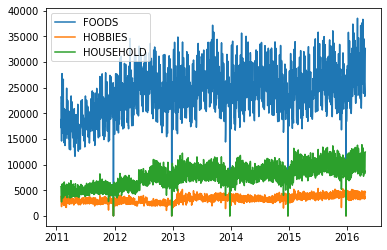

In [15]:
cat_df.plot();

**store_df:**

*Суммарные продажи товаров по магазинам, т.е. впринципе по точкам сети Walmart в независимости от штата.*

In [17]:
store_df = sales_df.drop(['id','item_id','cat_id','dept_id','state_id'], axis=1) # Лишнии столбцы.
store_df = store_df.groupby('store_id').sum().T                                  # Cтолбцы <-> строки.
store_df.index = [date(2011,1,29) + timedelta(delta) for delta in range(1913)]   # Переименовываем.
store_df.columns.name = ''                                                       # Просто так красивее)
store_df.iloc[[0,1,1000,-1]]

,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
2011-01-29,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038
2011-01-30,4155,3046,4827,1777,2687,3937,3006,2194,1922,4198
2013-10-25,3955,3078,5745,2179,2510,3954,2680,3155,3821,2800
2016-04-24,6113,6082,7721,3271,4033,4292,3957,4874,5127,4325


**desc_pr_df (describe price data frame):**

*Подробные статистики всех 3049 типов товаров.*

In [19]:
desс_pr_df = price_df.drop(['store_id','wm_yr_wk'], axis=1).groupby('item_id').describe()
desс_pr_df.columns = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'] # Избавляемся от мультииндексов.
desс_pr_df.index.name = ''                                                       # Просто так красивее)
desс_pr_df

,count,mean,std,min,25%,50%,75%,max
,,,,,,,,
FOODS_1_001,2819.0,2.166623,1.162253e-01,0.99,2.00,2.24,2.24,2.24
FOODS_1_002,2819.0,8.933913,4.856839e-01,7.66,8.88,8.88,9.48,9.48
FOODS_1_003,2820.0,2.975184,1.560816e-01,2.50,2.88,2.88,3.23,3.23
FOODS_1_004,2250.0,1.848631,1.066270e-01,1.50,1.78,1.78,1.96,1.96
FOODS_1_005,2817.0,3.329372,1.962105e-01,0.10,3.28,3.28,3.54,3.54
...,...,...,...,...,...,...,...,...
HOUSEHOLD_2_512,2814.0,3.969964,2.699552e-02,2.67,3.97,3.97,3.97,4.27
HOUSEHOLD_2_513,1683.0,2.780000,4.619901e-14,2.78,2.78,2.78,2.78,2.78
HOUSEHOLD_2_514,2817.0,18.797089,9.165032e-01,1.00,17.94,18.97,18.97,20.97


*Интересно, в Калифорнии в среднем товары типа 'продукты' и 'товары для дома' покупают в 1.5 раза больше, а 'товары для хобби' аж в 2 раза.*
Я предположительно объясняю это кол-вом населения и уровнем дохода.

In [18]:
sales_df.groupby(['state_id','cat_id']).sum().T.agg(['mean', 'std']).T

mean          std
CA FOODS      10034.658651  2128.135128
   HOBBIES     1589.065865   361.813686
   HOUSEHOLD   3366.106639   997.791471
TX FOODS       6772.828542  1337.459426
   HOBBIES      832.377940   205.455413
   HOUSEHOLD   2274.043910   660.984530
WI FOODS       6762.789336  1909.299499
   HOBBIES      780.228960   200.639253
   HOUSEHOLD   1929.462624   626.836167

#***4 этап. Визуальный анализ данных.***

*На выходе из 3-его этапа имеем следующие агрегированные датасеты:*

*    **main_df:** *Датасет, в котором хранится кол-во продаж для каждого товара за последнии 1913 дней.*

*    **price_sales_df:** *Содержит информацию о каждом продукте в виде: ср. цена, ср. кол-во продаж.*

*    **subcat_df:** *Содержит информацию о суммарных покупках во всех штатах, сгруппированных по субкатегориям товаров.*

*    **cat_df:** *Содержит информацию о суммарных покупках, сгруппированных по категориям товаров.*

*    **store_df:** *Суммарные продажи товаров по магазинам, т.е. впринципе по точкам сети Walmart в независимости от штата.*

*    **desc_pr_df:** *Подробные статистики всех 3049 типов товаров.*


##**Начнем визуальный анализ с датасета desc_pr_df:**


In [21]:
desс_pr_df.head()

,count,mean,std,min,25%,50%,75%,max
,,,,,,,,
FOODS_1_001,2819.0,2.166623,0.116225,0.99,2.00,2.24,2.24,2.24
FOODS_1_002,2819.0,8.933913,0.485684,7.66,8.88,8.88,9.48,9.48
FOODS_1_003,2820.0,2.975184,0.156082,2.50,2.88,2.88,3.23,3.23
FOODS_1_004,2250.0,1.848631,0.106627,1.50,1.78,1.78,1.96,1.96
FOODS_1_005,2817.0,3.329372,0.196211,0.10,3.28,3.28,3.54,3.54


*Как мы знаем медиана, в качестве модели среднего, больше устойчива к выбросам, но на первый взгляд мы наблюдаем очень схожие значения медиан и значения средних арифмитических, это странно, это может говорить о том, что данные очень хорошо распределены и не имеют выбросов, либо напротив, выбросы настолько сильные, что медиана не может их 'поймать'. Посмотрим немного на визуализацию данных, чтобы выяснить в чем дело.*

In [0]:
plt.rc('figure', figsize=(20,15))       # Устанавливаем размеры графиков.
font = {'family' : 'monospace'}
plt.rc('font', **font)

*Построим **дашборд гистограмм** по датасету **desc_pd_df** агригированного по разным статистикам распределения цены.*

In [0]:
names = ['Понедельный спрос на товар.(+1 если товар был продан на недели, +0 иначе)', 'Средняя цена на товар.',
         'Стандартное отклонение от среднего.', 'Минимальная цена на товар.',
         '0.25 квантиль распределения цены.', 'Медианная цена на товар.',
         '0.75 квантиль распределения цены.', 'Максимальная цена на товар.']

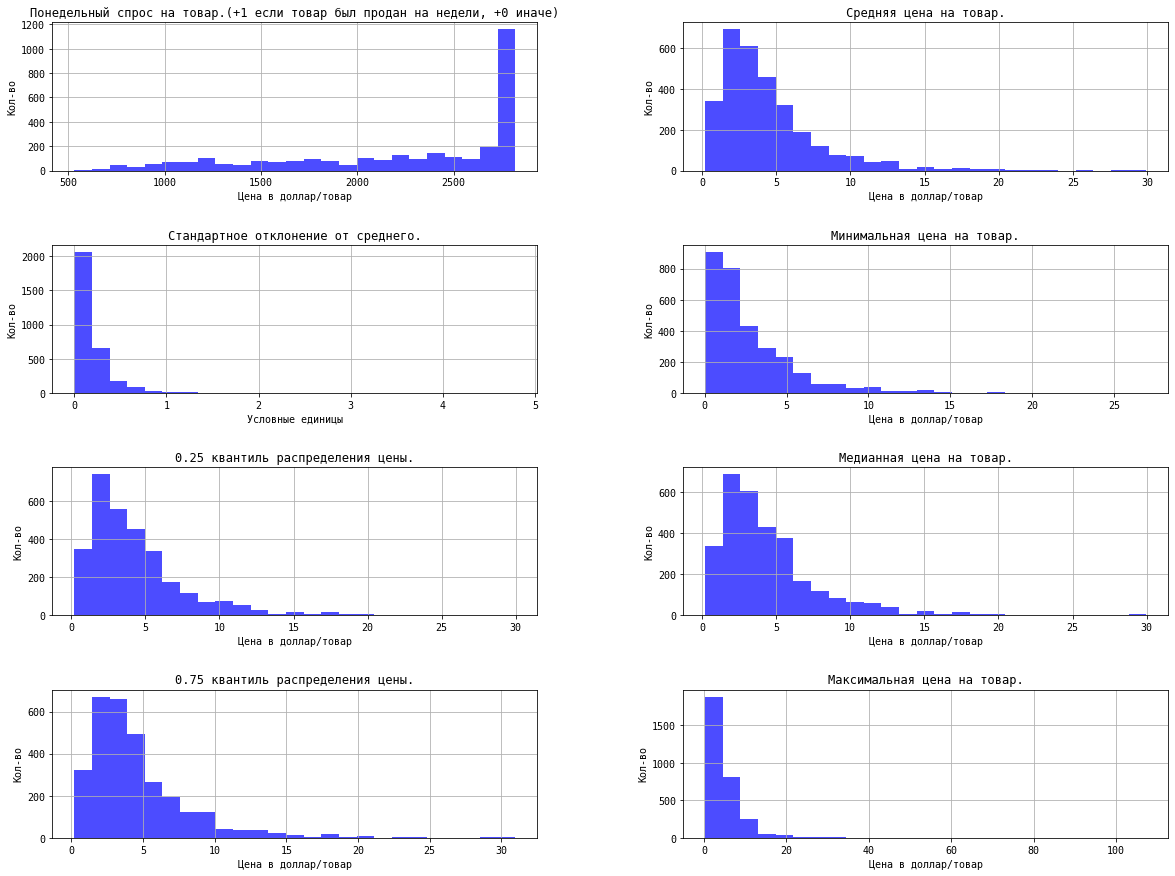

In [24]:
plt.rc('figure', figsize=(20,15))
fig, axes = plt.subplots(4, 2)

for id_ in range(8):
  row_id = int(id_ / 2)
  col_id = id_ % 2
  axes[row_id,col_id].hist(desс_pr_df.iloc[:,id_].to_list(), bins=25, color='b', alpha=0.7);
  axes[row_id,col_id].set_title(names[id_]) 
  axes[row_id,col_id].set_xlabel('Цена в доллар/товар')
  axes[row_id,col_id].set_ylabel('Кол-во')
  axes[row_id,col_id].grid()
axes[1,0].set_xlabel('Условные единицы')

plt.subplots_adjust(wspace=0.3, hspace=0.5) # Задаем пустое пространство между графиками. 

plt.show()
plt.close()

**Заметим что на внешний вид все статистики обладают схожим распределением с логнормальным.**

*К тому же, мы видим, что некоторые графики довольно схожи, но перед тем как делать некоторые выводы давайте еще чуть подробней посмотим всё-таки распределения, а конкретно распределение стандартных отклонений и построим пару полей рассеивания (scatter'ов).*

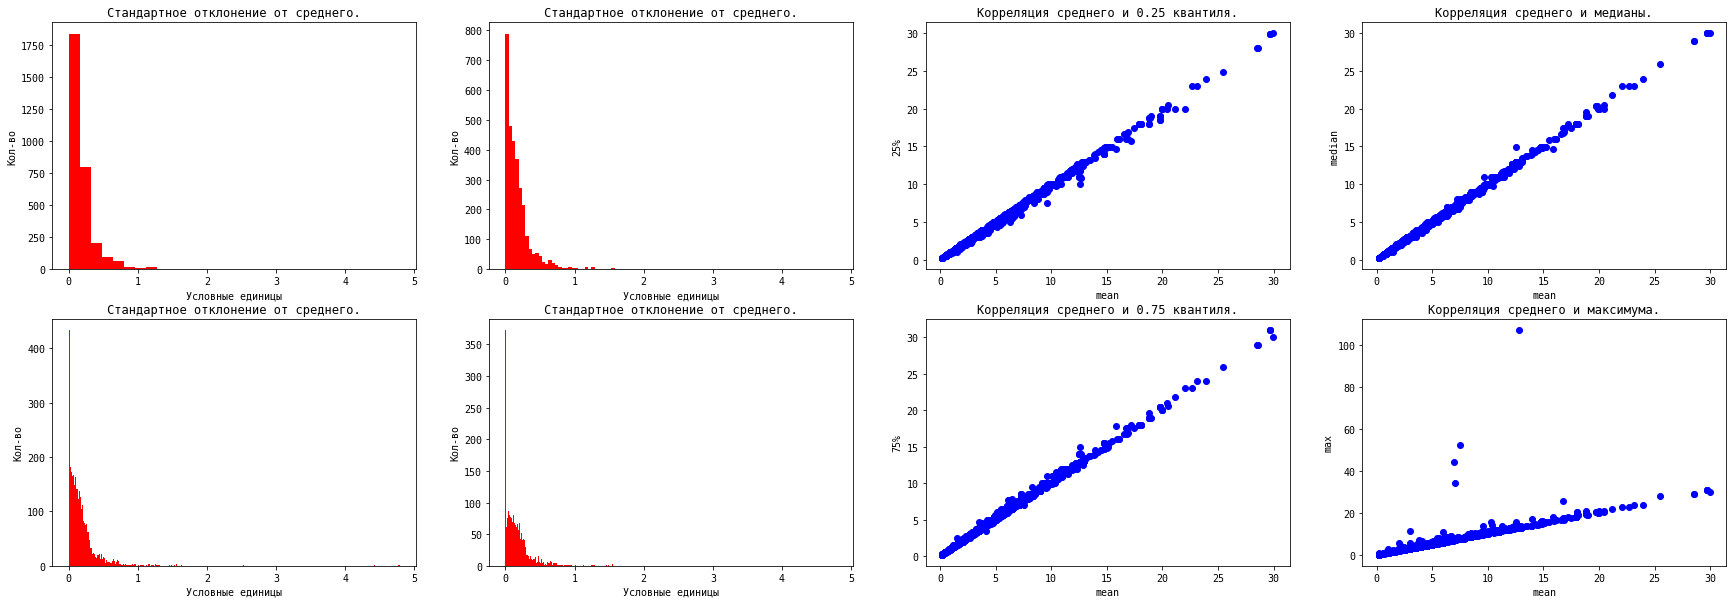

In [25]:
plt.rc('figure', figsize=(30,10))
fig, axes = plt.subplots(2, 4)
bin_list = [30,100,300,600]

for id_ in range(4):
  row_id = int(id_ / 2)
  col_id = id_ % 2
  axes[row_id,col_id].hist(desс_pr_df['std'].to_list(), bins=bin_list[id_], color='r', alpha=1);
  axes[row_id,col_id].set_title('Стандартное отклонение от среднего.') 
  axes[row_id,col_id].set_xlabel('Условные единицы')
  axes[row_id,col_id].set_ylabel('Кол-во')


axes[0,2].scatter(desс_pr_df['mean'].to_list(), desс_pr_df['25%'].to_list(), color='b', alpha=1)
axes[0,2].set_title('Корреляция среднего и 0.25 квантиля.')
axes[0,2].set_xlabel('mean')
axes[0,2].set_ylabel('25%')

axes[0,3].scatter(desс_pr_df['mean'].to_list(), desс_pr_df['50%'].to_list(), color='b', alpha=1)
axes[0,3].set_title('Корреляция среднего и медианы.')
axes[0,3].set_xlabel('mean')
axes[0,3].set_ylabel('median')

axes[1,2].scatter(desс_pr_df['mean'].to_list(), desс_pr_df['75%'].to_list(), color='b', alpha=1)
axes[1,2].set_title('Корреляция среднего и 0.75 квантиля.')
axes[1,2].set_xlabel('mean')
axes[1,2].set_ylabel('75%')

axes[1,3].scatter(desс_pr_df['mean'].to_list(), desс_pr_df['max'].to_list(), color='b', alpha=1)
axes[1,3].set_title('Корреляция среднего и максимума.')
axes[1,3].set_xlabel('mean')
axes[1,3].set_ylabel('max')

plt.subplots_adjust(wspace=0.2, hspace=0.2) # Задаем пустое пространство между графиками.

plt.show()
plt.close()

**Таким образом наблюдаем следующую картину:**

*Все данные, за исключением count обладают распределением, внешне схожим с логнормальны.*

*При этом наблюдается очень большая схожесть их гистограмм, это с достаточной степенью уверенности говорит об очень высокой линейной зависимости 0.25 квантиля, среднего, медианы, 0.75 квантиля и максимума, это подтверждается также визуализацией соответствующих полей рассеивания.*

*Также посмотрим на гистограммы стандартных отклонений, при увиличении bin'ов мы наблюдаем 1 сильно выделяющийся бин в районе нуля, что говорит о том, что скорей всего некоторое значение или значения из очень маленькой области очень частно встречаются в датасете, если говорить более человеческим языком, то это говорит о том, что цены имеют некоторый характер устойчивости, т.е. цена на товар с течением времени не изменяется, а если изменяется, то не существенно, поэтому такой ярко выраженный бин естесвенен и в принципе ожидаем.*

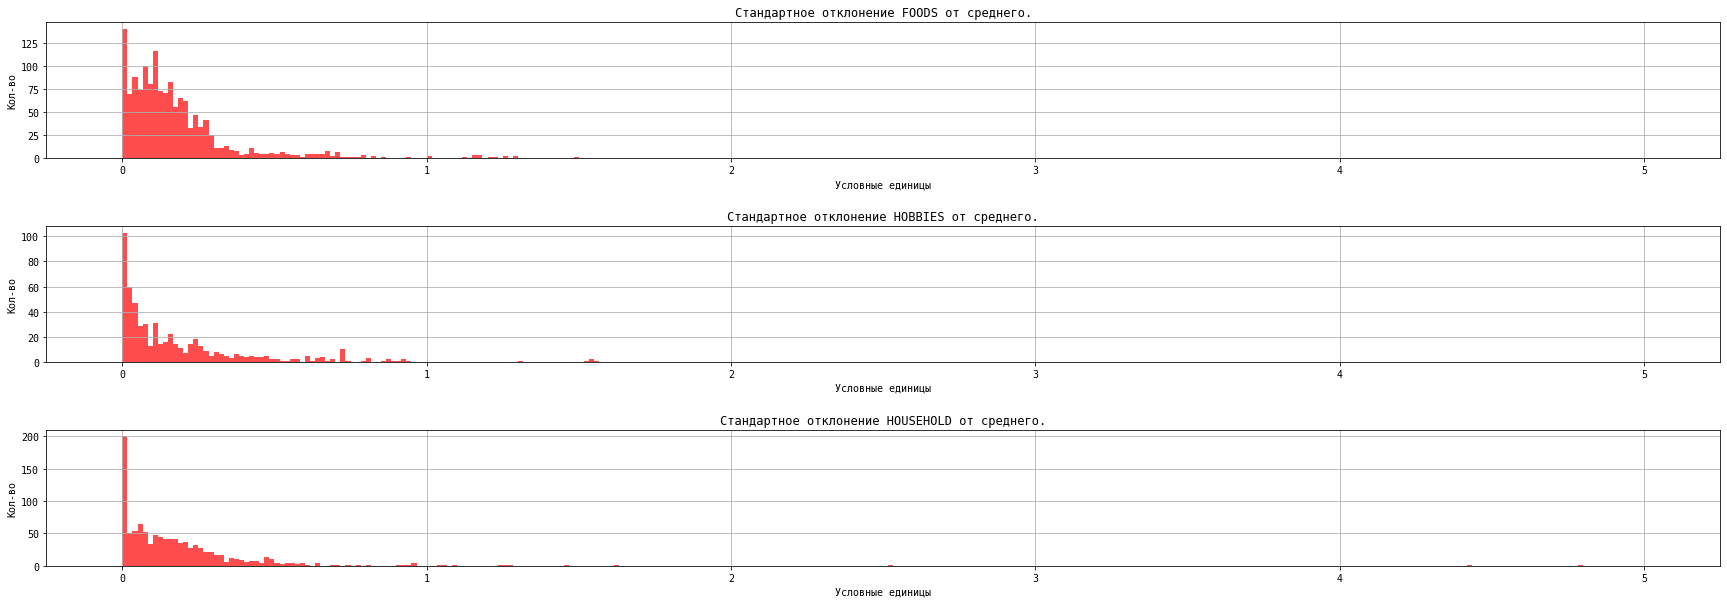

In [26]:
plt.rc('figure', figsize=(30,10))
fig, axes = plt.subplots(3,1)
names = ['FOODS', 'HOBBIES', 'HOUSEHOLD']

for id_ in range(3):
  tmp = desс_pr_df.loc[[names[id_] in word for word in desс_pr_df.reset_index().iloc[:,0].to_list()]]['std']
  axes[id_].hist(tmp, bins=300, color='r', alpha=0.7, range=(0,5), label=names[id_]);
  axes[id_].set_title('Стандартное отклонение ' + names[id_] + ' от среднего.') 
  axes[id_].set_xlabel('Условные единицы')
  axes[id_].set_ylabel('Кол-во')
  axes[id_].grid()
plt.subplots_adjust(hspace=0.5)

plt.show()
plt.close()

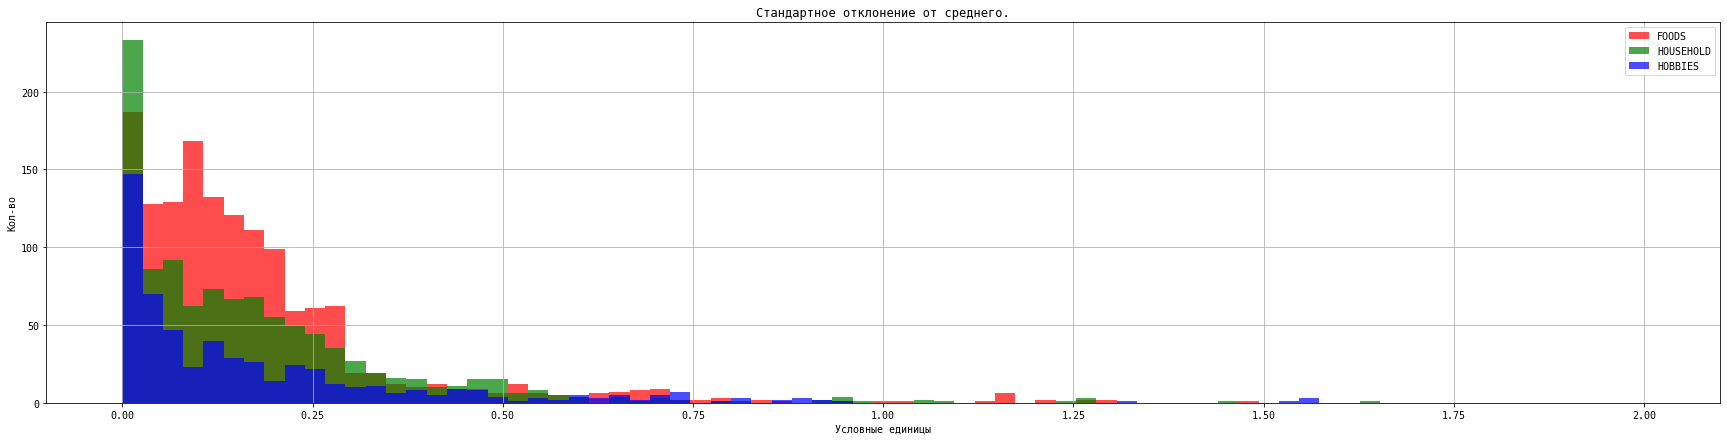

In [27]:
plt.rc('figure', figsize=(30,7))
fig, axes = plt.subplots(1,1)
names = ['FOODS', 'HOUSEHOLD', 'HOBBIES']
colors = ['r','g','b']

for id_ in range(3):
  tmp = desс_pr_df.loc[[names[id_] in word for word in desс_pr_df.reset_index().iloc[:,0].to_list()]]['std']
  axes.hist(tmp, bins=75, color=colors[id_], alpha=0.7, range=(0,2), label=names[id_]);

axes.legend()
axes.set_title('Стандартное отклонение от среднего.') 
axes.set_xlabel('Условные единицы')
axes.set_ylabel('Кол-во')
axes.grid()
plt.subplots_adjust(hspace=0.4)

plt.show()
plt.close()

*Из последних двух дашбордов можем заметить, что отклонение цены на продукты питания выше, чем отклонение цен на товары домашнего хозяйства и хобби.*

*Что интуитивно тоже естественно, на продуты чаще скидки, чем на другие товары, продукты как товар, больше подвержен.*

*Стоит еще заметить, что из всех гистограмм можно сделать вывод, что цена на товары в основном не изменяется, но если изменяется, то своеброзным скачком, то есть она не растет на 1 цент, а условно сразу на 3-5, ведь не естественно было бы, если бы в магазинах ценник мог бы подняться на столь незначительную величину как 1-10 копеек.*


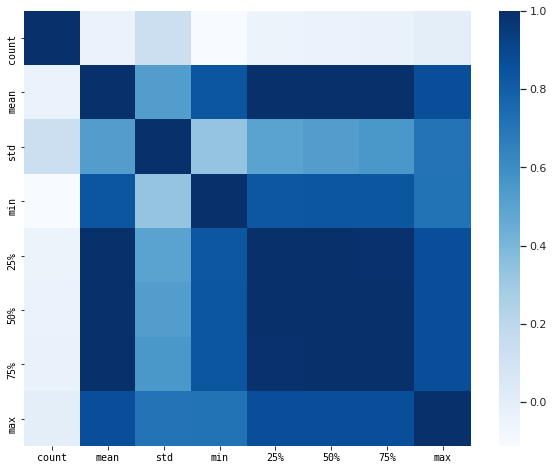

In [28]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(111)

sns.set(style="ticks", color_codes=True)
sns.heatmap(ax=ax1, data=desс_pr_df.corr(), cmap='Blues')
# pair_corr = sns.pairplot(data=desс_pr_df, diag_kind='kde') # Как еще один вариант исследования корреляции.
# pair_corr.fig.set_size_inches(7,7) 

plt.show()
plt.close()

##**Посмотрим на визуализацию main_df:**


**Давайте взглянем на сразу несколько дашбордов.**
*Провизуализируем несколько произворльных товаров, лежащих в одном магазине в штате Калифорния, и может быть что-то увидим интересное.*

In [0]:
# Для поиска средних товаров, фильтруя по названиям.

def mean_time_series(name_1, name_2=''):

  if not name_2:
    name_2 = name_1
  
  com = np.zeros(main_df['_1'].to_numpy().shape)

  rand_num = [name_ for name_ in id_dict.keys() if name_1 in name_ and name_2 in name_]
  rand_num = [int(id_dict[id_][1:]) for id_ in rand_num if id_ in id_dict.keys()]

  for id_ in range(len(rand_num)):
    com += main_df['_'+str(rand_num[id_])].to_numpy()
  com /= len(rand_num)

  return com

In [0]:
type_names = ['HOBBIES_1','HOBBIES_2',
              'FOODS_1','FOODS_2','FOODS_3', 
              'HOUSEHOLD_1','HOUSEHOLD_2']

state_names = ['CA', 'TX', 'WI']     
               
data_series_types  = {type_name:  mean_time_series(type_name)  for type_name  in type_names}
data_series_states = {state_name: mean_time_series(state_name) for state_name in state_names}

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates
import datetime as dt

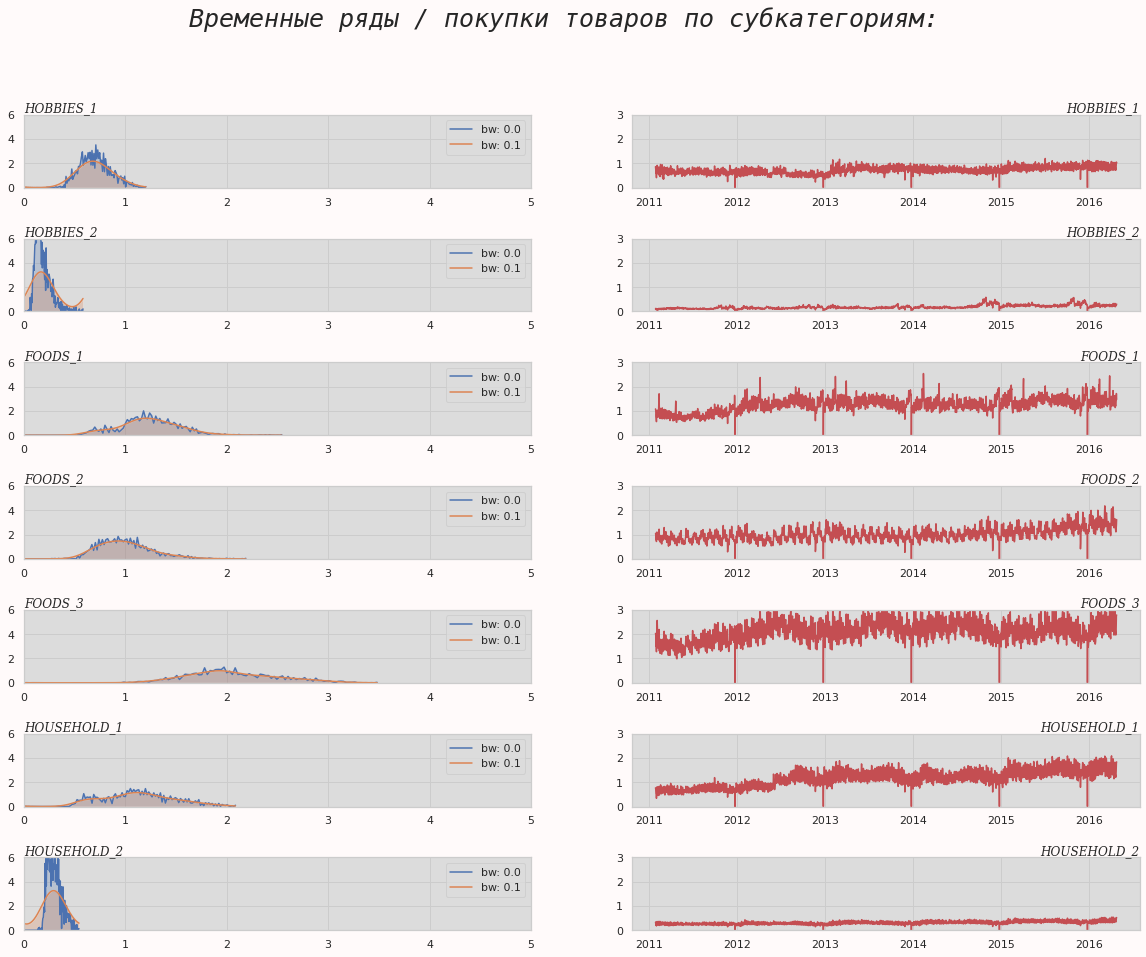

In [32]:
sns.set(style='whitegrid', rc={'figure.facecolor': 'snow', 'axes.facecolor': 'gainsboro'})
# plt.style.use('ggplot')  # Красивые графики

fig, axes = plt.subplots(len(data_series_types),2, figsize=(20,15))
fig.suptitle('Временные ряды / покупки товаров по субкатегориям:',
             fontsize = 25,            
             fontfamily = 'monospace',
             fontstyle  = 'oblique')

for id_y, type_name in enumerate(type_names):

  sns.kdeplot(ax=axes[id_y,0],           data=data_series_types[type_name], shade=True, cut=0, bw=.0, label="bw: 0.0")
  graphic = sns.kdeplot(ax=axes[id_y,0], data=data_series_types[type_name], shade=True, cut=0, bw=.1, label="bw: 0.1")
  graphic.set_xlim(0, 5)
  graphic.set_ylim(0, 6)
  axes[id_y,0].set_title(type_name,
                         loc='left',
                         fontsize=12,
                         fontfamily = 'serif',
                         fontstyle  = 'italic',
                         pad=3)
  
  time_interval = [dt.datetime.strptime(i, "%Y-%m-%d") for i in main_df.index] # Получаем интервалы времени в нужном виде.

  graphic = sns.lineplot(ax=axes[id_y,1], x=time_interval, y=data_series_types[type_name], color='r') # Рисуем плотность распределения.
  graphic.set_ylim(0, 3)
  axes[id_y,1].set_title(type_name,
                         loc='right',
                         fontsize=12,
                         fontfamily = 'serif',
                         fontstyle  = 'italic',
                         pad=3)    

plt.subplots_adjust(wspace=0.2, hspace=0.7)

plt.show()
plt.close()

**По дашборду выше можем увидеть явные отличия плотностей распределений кол-ва продаж:**

*    *У FOODS_3 самый высокий средний уровень, видимо это тип продуктов, которые чаще всего употребляются в рядов питании, т.е. рис, хлеб, мясо, об этом говорит некая внешная сезонность в рамках времен года, летом - средний спрос выше, зимой - средний спрос ниже.*

*    *FOODS_1, FOODS_2 более специфичны, однако FOODS_2 обладает более яркой сезонностью и по-видимому постоянной скользящей дисперсией, очень вероятно ряд стационарен, так же стоит обратить внимание, что кол-во пиков от года к году, их ровно 12 и они достигаются в начале месяца, т.е. это быть может товары со скидкой или что-то в роде того, FOODS_1 же имеет большую дисперсию.*

*    *HOUSEHOLD_2 и HOBBIES_2 имеют самый низкий средний уровень, что говорит нам о том, что это товары не обладающими высоким спросом, по видимому это дорогие товары-хобби и спицифические товары хозяйства, вероятно расход которых невероятно длителен, т.е. что-то наподобии солонок для соли, посуды, предметов мебели и т.д.*

*    *HOUSEHOLD_1 же напротив, довольно популярен, но который до середины 2012 года имел явно более низкий средний уровень, об этом говорит так же бинормальное распределения плотности, скорей всего это туалетная бумага, мыло, средства для мытья посуды и т.п. тратящиеся товары.*

*В то же время, напомним, что графики справа являются временными рядам, где каждое значеие по каждой дате взято по всем единицам товара и уреднено по их кол-вам. Но у каждого из них есть резкий спад в предверии нового года, мы уже наблюдали его и предположили, что это связанно с рождеством, в очередной раз убеждаемся, что это навярняка так.*


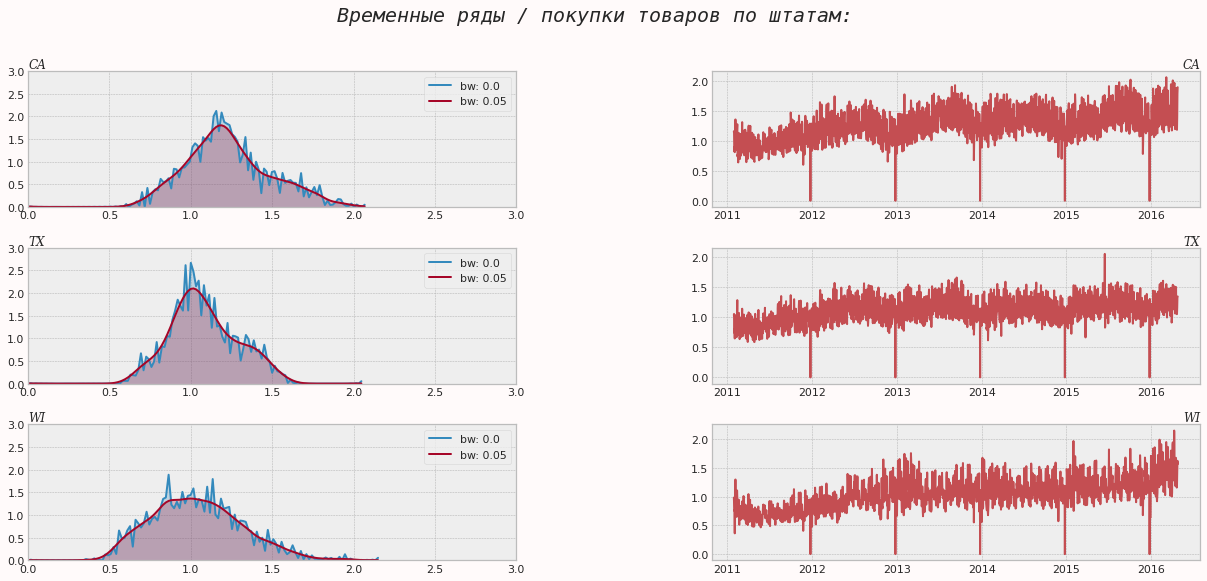

In [33]:
plt.style.use('bmh')  # Красивые графики

fig, axes = plt.subplots(len(data_series_states),2, figsize=(21,9))
fig.suptitle('Временные ряды / покупки товаров по штатам:',
             fontsize = 20,            
             fontfamily = 'monospace',
             fontstyle  = 'oblique')

for id_, state_name in enumerate(state_names):

  sns.kdeplot(ax=axes[id_,0],            data=data_series_states[state_name], shade=True, cut=0, bw=.00, label="bw: 0.0")  
  graphic = sns.kdeplot(ax=axes[id_,0],  data=data_series_states[state_name], shade=True, cut=0, bw=.05, label="bw: 0.05")  
  graphic.set_xlim(0, 3)
  graphic.set_ylim(0, 3)
  axes[id_,0].set_title(state_name,
                        loc='left',
                        fontsize=12,
                        fontfamily = 'serif',
                        fontstyle  = 'italic',
                        pad=3)
  
  time_interval = [dt.datetime.strptime(i, "%Y-%m-%d") for i in main_df.index] # Получаем интервалы времени в нужном виде.  
  
  graphic = sns.lineplot(ax=axes[id_,1], x=time_interval, y=data_series_states[state_name], color='r')
  axes[id_,1].set_title(state_name,
                        loc='right',
                        fontsize=12,
                        fontfamily = 'serif',
                        fontstyle  = 'italic',
                        pad=3)    
      
plt.subplots_adjust(wspace=0.4, hspace=0.3)

plt.show()
plt.close()

**На дашборде выше, мы наблюдаем обратную картину предыдущей, мы построили 3 пары графиков, характеризующих средний спросы на товары вообще по штатам:**

*Можем наблюдать, что у всех наблюдается сезонность порядка года, т.е. повышение спроса на товары летом и понижения зимой, вероятней всего это связанно с нежеланием выходить на улицу в холодное время года.*

*Калифорния обладает схожей с Техасом сезонностью со снижением от лета к зиме, но в Калифорнии сезонность более выражена, вероятно это связанно с тем, что Калифорния находится у океана и северней, нежели Техас, отсюда и мокрый воздух зимой и более изменчивая температура.*

*У штата Висконсин может набюлюдать тренд. Предположительно это связанно с ростом численности населения штата из источников о демографии штата, действительн, становится известно, что за последнии 10 лет численность штата выросла c 5'500'000 до 6'000'000 человек. Вероятно это и попуждает увеличения кол-ва покупок товаров.*

*Так же в Техасе можно наблюдать резкий подъем спроса в окрестности мая-июня 2015 года, очень интересно, но в конце мая 2015 года вышел сериал "Техас", что-то в этом есть)*

##**Посмотрим на визуализацию subcat_df, агригированного по событиям:**

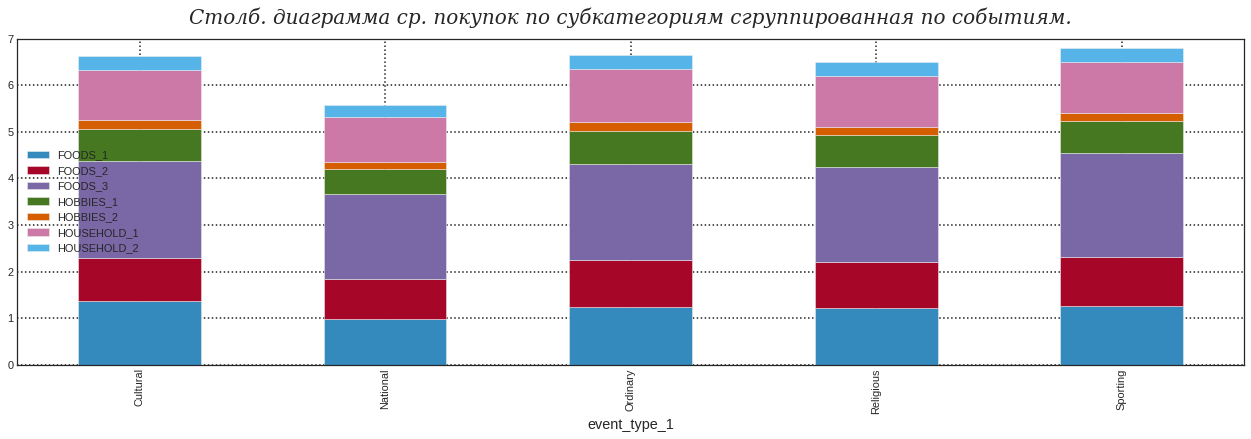

In [47]:
plt.style.use('seaborn-white')
fig = plt.figure(figsize=(22,6));
ax = fig.add_subplot(111)
diagr = subcat_df.drop(['snap_CA','snap_TX','snap_WI'], axis=1).groupby('event_type_1').mean().plot.bar(ax=ax,stacked=True);

diagr.set_title('Столб. диаграмма ср. покупок по субкатегориям сгруппированная по событиям.',
             fontsize=20,
             fontfamily = 'serif',
             fontstyle  = 'italic',
             pad=15);

diagr.set_ylim(0, 7)
plt.grid(color='k',
         linestyle='dotted',
         linewidth=1.5)

**Ничего особо интересного не наблюдается, но давайте попробуем выявиться какие-нибудь инсайды.** 

*    *Чуть-чуть уменьшаются среднии затраты в дни с национальными празниками, может быть это связанно с тем, что большинство жителей стараются проводить такие дни с семьей и все продукты, подарки и т.п. закупаются заранее.* 
*    *В дни, на которые приходятся спортивные события, наблюдается небольшой прирост в средних покупках продуктов субкатегории FOODS_3, это говорит о вероятности того, что эта субкатегория содержит продукты быстрого питания, такие как бургеры, хотдоги и т.п. товары, которые продаются на различных мероприятих таких как футбольные матчи, боксерские поединки. (Ранее мы говорили, что FOODS_3 может быть рядовой субкатегорией продуктов, однако тут наблюдаем другое предположения, так что напомним, что это все условности, ничего формального мы пока не говорим, все статистические обоснованности будут в следующем этапе сполна.)*

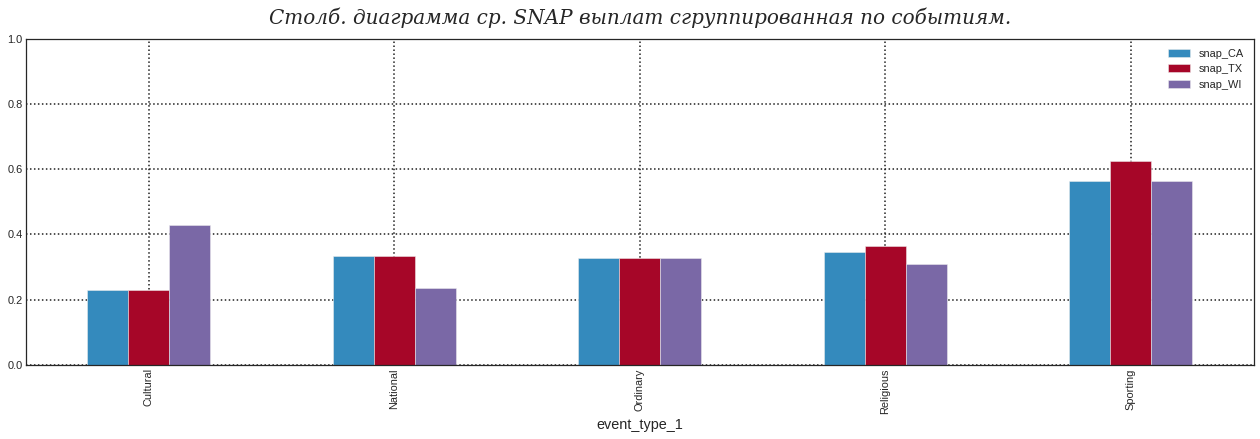

In [48]:
plt.style.use('seaborn-white')
fig = plt.figure(figsize=(22,6));
ax = fig.add_subplot(111)
diagr = subcat_df.loc[:,['event_type_1','snap_CA','snap_TX','snap_WI']].groupby('event_type_1').mean().plot.bar(ax=ax);

diagr.set_title('Столб. диаграмма ср. SNAP выплат сгруппированная по событиям.',
             fontsize=20,
             fontfamily = 'serif',
             fontstyle  = 'italic',
             pad=15);

diagr.set_ylim(0, 1)
plt.grid(color='k',
         linestyle='dotted',
         linewidth=1.5)

*На этой диаграмме также ничего особо примичательного не наблюдается, единственное, что можно зметить это то, что по культурным праздникам штат Висконсин старается выплачивать SNAP почаще и что на дни, в которые проходят события связанные со спортом, приходятся выплаты в 1.5 раза чаще, чем на рядовые дни.*

#***5 этап. Проверка статистических гипотез:***

**Составим ряд H0 (пасивных) гипотез, которые затем будем проверять:**

*    Товары субкатегории FOODS_3 во всех штатах покупают одинаково часто.    
*    Дешевые товары покупают так же часто как и дорогие.
*    SNAP льготы не влияют на спрос продуктов категории FOODS.
*    Товары всех субкатегорий одинаково часто покупают.

**Везде будем считать уровень значимости p = 0.05**


##**1 гипотеза: товары FOODS_3 покупают во всех штатах одинково.**
H0: *Выборки, состоящие из данных собранных по 3 штатам товара FOODS_3, взяты из одной генеральной совокупности.*


H1: *Выборки, состоящие из данных собранных по 3 штатам товара FOODS_3, взяты не из одной генеральной совокупности.*

In [0]:
foods_state = {'CA': mean_time_series('FOODS_3', 'CA'),
               'TX': mean_time_series('FOODS_3', 'TX'),
               'WI': mean_time_series('FOODS_3', 'WI')}

*Будем далее использовать для опровержения или принятия этой гипотезы, **критерий ANOVA** (или критерий Фишера).*


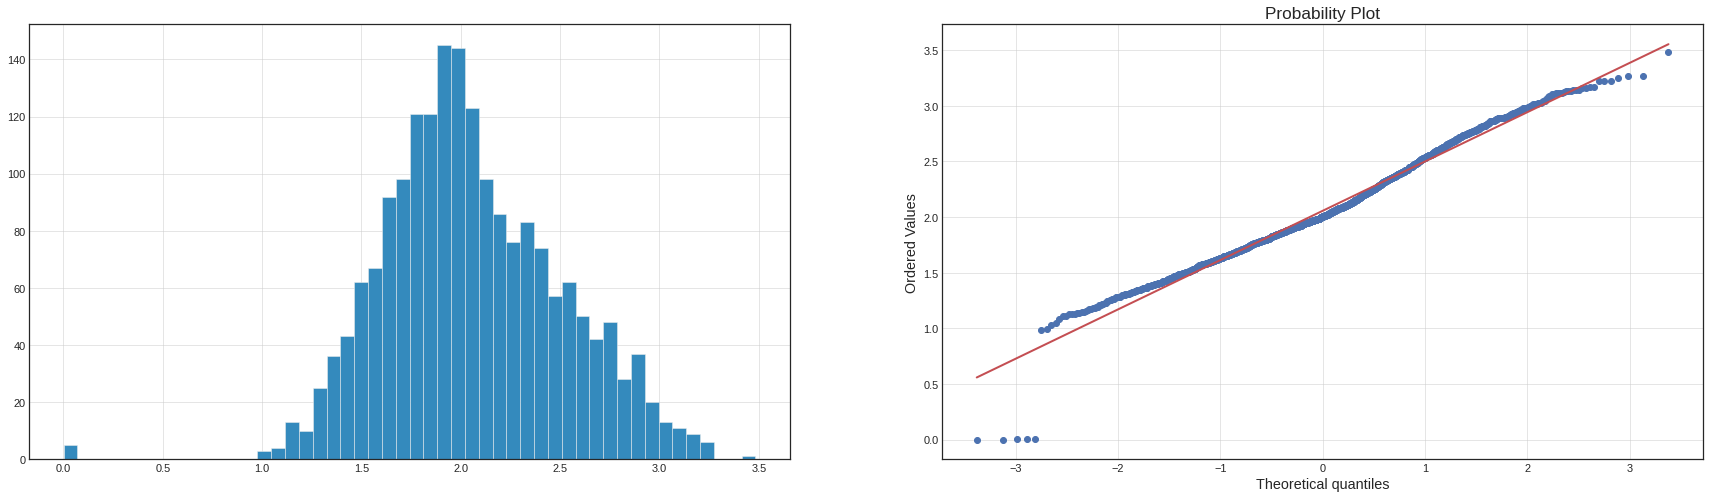

In [50]:
# Убедимся, что наши данные имеют нормальное распределение, воспользовавшись методом Q-Q.

fig = plt.figure(figsize=(30,8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
accumulate_data = mean_time_series('FOODS_3')
ax1.hist(accumulate_data, bins=50);
ax2 = stats.probplot(accumulate_data, dist="norm", plot=plt);

ax1.grid()
plt.grid()

plt.show()
plt.close()

Получаем подтверждение того, что данные распределены околонормально.

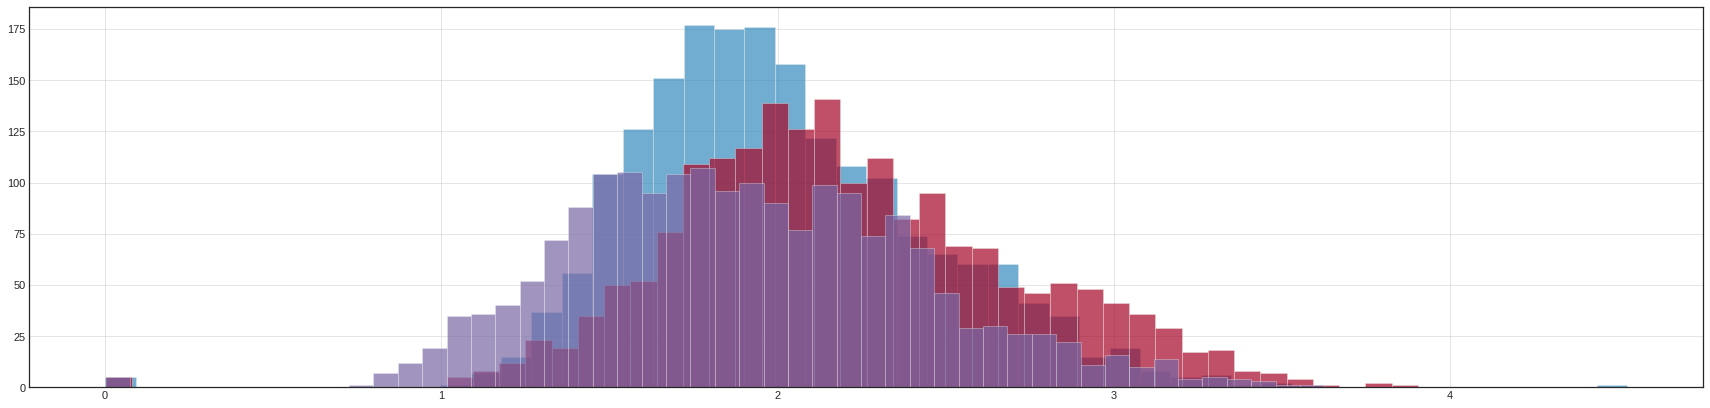

In [52]:
plt.hist(foods_state['TX'], bins=50, alpha=0.7); 
plt.hist(foods_state['CA'], bins=50, alpha=0.7); 
plt.hist(foods_state['WI'], bins=50, alpha=0.7); 
stats.shapiro(foods_state['TX'])
plt.grid()

In [53]:
print('Стандартная ошибка среднего по FOODS_3 в штате CA: %.4f' % stats.sem(foods_state['CA']))
print('Стандартная ошибка среднего по FOODS_3 в штате TX: %.4f' % stats.sem(foods_state['TX']))
print('Стандартная ошибка среднего по FOODS_3 в штате WI: %.4f' % stats.sem(foods_state['WI']))

Стандартная ошибка среднего по FOODS_3 в штате CA: 0.0115
Стандартная ошибка среднего по FOODS_3 в штате TX: 0.0100
Стандартная ошибка среднего по FOODS_3 в штате WI: 0.0117


*Очень низкие значения стандартных ошибок средних, говорят нам о том, что соответствующие выборочные средние очень точно приближают средние из соответствующх генеральных совокупностей.*

In [54]:
print('Выборочное стандартное отклонение по FOODS_3 в штате CA: %.4f' % np.std(foods_state['CA']))
print('Выборочное стандартное отклонение по FOODS_3 в штате TX: %.4f' % np.std(foods_state['TX']))
print('Выборочное стандартное отклонение по FOODS_3 в штате WI: %.4f' % np.std(foods_state['WI']))

Выборочное стандартное отклонение по FOODS_3 в штате CA: 0.5044
Выборочное стандартное отклонение по FOODS_3 в штате TX: 0.4374
Выборочное стандартное отклонение по FOODS_3 в штате WI: 0.5129


*Наблюдаем достаточно близкие значения диспресий.*

*Рассмотрим группу сэмплов, которую имеем:*

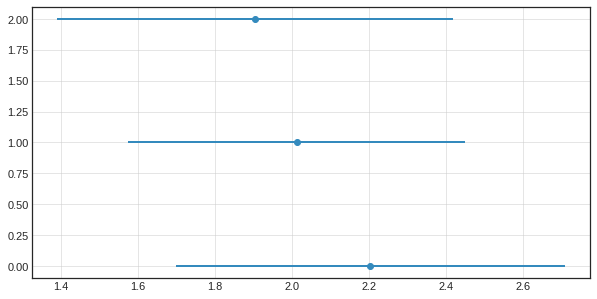

In [55]:
numpyed_dict = np.array([list(arr) for arr in foods_state.values()])
x = np.mean(numpyed_dict, axis=1)
y = np.arange(len(['CA','TX','WI']))
e = np.std(numpyed_dict, axis=1)

fig,ax = plt.subplots(0,0,figsize=(10,5))
ax = plt.errorbar(x, y, xerr=e, linestyle='None', marker='o');
plt.grid()

**Применяем критерий ANOVA:**

In [56]:
F, p = stats.f_oneway(foods_state['CA'], foods_state['WI'], foods_state['TX'])

print('Вероятность ошибочну отвергнуть верную гипотезу = %.3f, при уровне значимости p = 0.05.\n' % p)
print("порядок p:", p)

Вероятность ошибочну отвергнуть верную гипотезу = 0.000, при уровне значимости p = 0.05.

порядок p: 1.934747214086854e-78


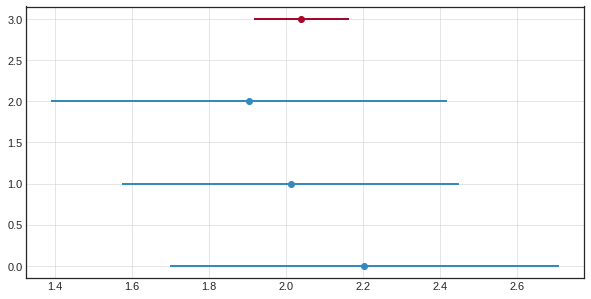

In [57]:
numpyed_dict = np.array([list(arr) for arr in foods_state.values()])
x = np.mean(numpyed_dict, axis=1)
y = np.arange(len(['CA','TX','WI']))
e = np.std(numpyed_dict, axis=1)


fig,ax = plt.subplots(0,0,figsize=(10,5))
ax = plt.errorbar(x, y, xerr=e, linestyle='None', marker='o')
ax = plt.errorbar(np.mean(x), y.shape[0], xerr=np.std(x), linestyle='None', marker='o');
plt.grid()
plt.show()
plt.close()

**Гипотеза H0 о том, что товары FOODS_3 в 3-ех штатах покупают одинаково отвергается при уровне значимости p = 0.05**

Если посмотреть на порядок значения p, то можно увидеть, что он невероятно мал. Такая уверенность критерия объясняется скорей всего достаточно большим размером выборки, т.е. данных достаточно много, чтобы можно было точно сказать о чем-то.

*Т.к. все три выбокри имеют нормальное распределение, являются независимыми и обладают близкими диспресиями, то с помощью **двухвыборочного t-критерия** (Стьюдента) для независимых (несвязных) выборок проанализируем дополнительно следующие 3 гипотезы:*
*    H0: FOODS_3 товары покупают в штатах CA и WI одинаково. CA!=WI
*    H0: FOODS_3 товары покупают в штатах WI и TX одинаково. WI!=TX 
*    H0: FOODS_3 товары покупают в штатах TX и CA одинаково. TX!=CA

*При том, что мы делаем в некотором смысле множественное сравнение, чтобы не допустить случайной статистической ошибки, введем поправку Бенфороне, т.е. понизим уровень значимости p = 0.05, до p = 0.01667 (0.05 / на кол-во сравнений) хоть и она редко применяется, но для нас подойдет.*

In [58]:
_, p_CA_WI = stats.ttest_ind(foods_state['CA'], foods_state['WI']) # FOODS_3 товары покупают в штатах CA и WI одинаково. CA!=WI
_, p_WI_TX = stats.ttest_ind(foods_state['WI'], foods_state['TX']) # FOODS_3 товары покупают в штатах WI и TX одинаково. WI!=TX
_, p_TX_CA = stats.ttest_ind(foods_state['TX'], foods_state['CA']) # FOODS_3 товары покупают в штатах TX и CA одинаково. TX!=CA

print("Вероятность ошибочно отвергнуть гипотезу СA!=WI:  %.3f" % p_CA_WI)
print("Вероятность ошибочно отвергнуть гипотезу WI!=TX:  %.3f" % p_WI_TX)
print("Вероятность ошибочно отвергнуть гипотезу TX!=CA:  %.3f" % p_TX_CA)

Вероятность ошибочно отвергнуть гипотезу СA!=WI:  0.000
Вероятность ошибочно отвергнуть гипотезу WI!=TX:  0.000
Вероятность ошибочно отвергнуть гипотезу TX!=CA:  0.000


**Все 3 гипотезы H0 о том, что товары FOODS_3 во всех парах штатов покупают одинаково отвергаются при уровне значимости p = 0.01667**

*Это говорит нам о том, что во всех 3 штатах спрос на товары типа FOODS_3 различный, хоть и исходя из проверенных выше критериев мы не можем сказать точнее про характер различности, но при этом уверенности результатов критериев говорят нам о том, что распределение покупок товара FOODS_3 в Калифорнии отличается от 2 других штатов сильнее, чем у них оно различается между собой.*

**Посмотрев на гистограмму, дополнительно проверим следующую гипотезу отедельно для всех 3 штатов:**

*    H0: Среднее кол-во продаж товаров в штате по субкатегории FOOD_3 равно 
*    H1: Среднее кол-во продаж товаров в штате по субкатегории FOOD_3 не равно

*Используем для этого одновыборочный критерий Стьюдента.*

In [59]:
_, p_CA = stats.ttest_1samp(a = foods_state['CA'], popmean=2.0)
_, p_TX = stats.ttest_1samp(a = foods_state['TX'], popmean=2.0)
_, p_WI = stats.ttest_1samp(a = foods_state['WI'], popmean=2.0)

print("Вероятность ошибочно отвергнуть гипотезу H0 об CA.mean = 2:  %.20f, с уровнем значимости p = 0.05" % p_CA)
print("Вероятность ошибочно отвергнуть гипотезу H0 об TX.mean = 2:  %.20f, с уровнем значимости p = 0.05" % p_TX)
print("Вероятность ошибочно отвергнуть гипотезу H0 об WI.mean = 2:  %.20f, с уровнем значимости p = 0.05" % p_WI)

Вероятность ошибочно отвергнуть гипотезу H0 об CA.mean = 2:  0.00000000000000000000, с уровнем значимости p = 0.05
Вероятность ошибочно отвергнуть гипотезу H0 об TX.mean = 2:  0.22579776644330323832, с уровнем значимости p = 0.05
Вероятность ошибочно отвергнуть гипотезу H0 об WI.mean = 2:  0.00000000000000074148, с уровнем значимости p = 0.05


##**2 гипотеза:** **дешевые товары покупают так же часто как и дорогие.**
H0: Товары, цены которых ниже средней, покупают также часто как и товары, цены которых выше.

H1: Спрос на товары, цены которых ниже средней цены и которых выше, различается.


In [60]:
price_sales_df.describe().T

,count,mean,std,min,25%,50%,75%,max
sell_price,3049.0,4.450568,3.517675,0.201203,2.160351,3.419148,5.840688,29.944663
mean_sales,3049.0,1.126322,2.313248,0.029692,0.225301,0.497961,1.118975,52.406116


Средняя цена на товары, вне зависимости от категорий: 4.45$


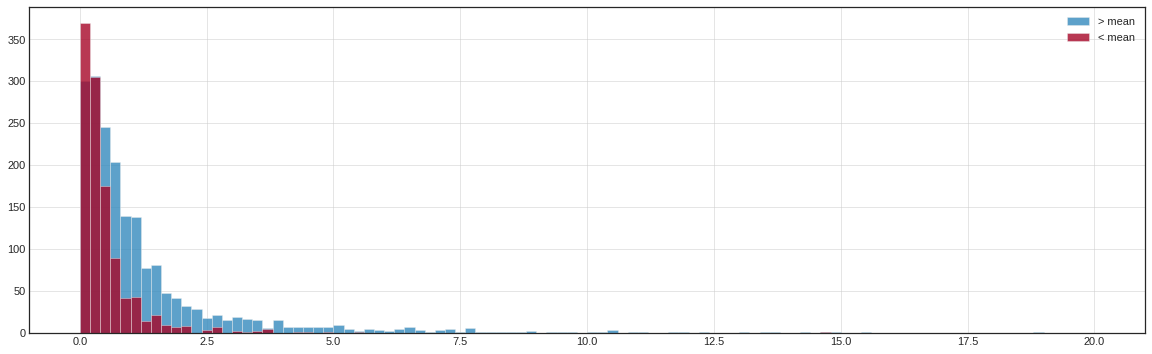

In [61]:
plt.rc('figure', figsize=(20,6))       

mean_price = price_sales_df.sell_price.mean()
print('Средняя цена на товары, вне зависимости от категорий: %.2f$' % mean_price)

below_mean = price_sales_df.query('sell_price <  @mean_price').mean_sales.to_numpy()
above_mean = price_sales_df.query('sell_price >= @mean_price').mean_sales.to_numpy()

plt.hist(below_mean, bins=100, range=(0,20), alpha=0.8, label = '> mean');
plt.hist(above_mean, bins=100, range=(0,20), alpha=0.8, label = '< mean');

plt.legend()
plt.grid()
plt.show()
plt.close()

*Как видим распределения не похожи на нормальны так что критерий Стьюдента тут не подходит, восползуемся критерием Хи-квадрат, чтобы проверить нашу пассивную гипотезу.*

In [62]:
stats.chi2_contingency(below_mean, above_mean)

(0.0,
 1.0,
 0,
 array([0.64019864, 0.70015682, 6.76847883, ..., 0.60402509, 0.41380031,
        0.05859906]))

*Как видим, результаты оказались статистически значимыми и мы отвергаем гипотезу H0 в пользу альтернативной.*

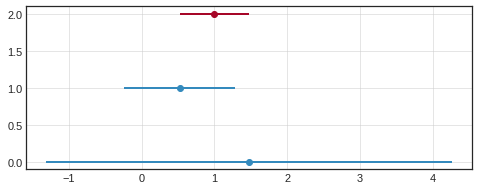

Среднее кол-во покупок товаров, цены которых ниже средней: 1.48
Среднее кол-во покупок товаров, цены которых выше средней: 0.52

Стандартная ошибка среднего спроса дешевых товаров: 0.0635
Стандартная ошибка среднего спроса дорогих товаров: 0.0228


In [63]:
x = [np.mean(below_mean), np.mean(above_mean)]
y = np.arange(len(x))
e = [np.std(below_mean), np.std(above_mean)]

fig,ax = plt.subplots(0,0,figsize=(8,3))
ax = plt.errorbar(x, y, xerr=e, linestyle='None', marker='o')
ax = plt.errorbar(np.mean(x), y.shape[0], xerr=np.std(x), linestyle='None', marker='o');
plt.grid()
plt.show()
plt.close()

print('Среднее кол-во покупок товаров, цены которых ниже средней: %.2f' % x[0])
print('Среднее кол-во покупок товаров, цены которых выше средней: %.2f\n' % x[1])
print('Стандартная ошибка среднего спроса дешевых товаров: %.4f' % stats.sem(below_mean))
print('Стандартная ошибка среднего спроса дорогих товаров: %.4f' % stats.sem(above_mean))

*Опровергнув гипотезу H0 в пользу H1, мы получаем очень уверенное статистическое подтверждение тому, что более дешевые товары и более дорогие покупают по-разному. Но критерий не дает точного характера этого различия, однако опираясь на значения средних в каждой из 2-ух групп и низкие величины стандартной ошибки среднего мы можем сделать очень уверенный вывод о том, что более дешевые товары, всё-таки покупают обладают большим спросом, нежели более дорогие.*

Но давайте всё-таки захотим получить некоторую статистическую количественную оценку, применить доверительные интервалы мы не можем, т.к. наблюдаем не нормальное распределеине, тогда давайте применим бутстреп - насэмплируем большие выборки с повторением, посчитаем у них средние и они в свою очередь будут распределены нормально по ЦПТ, тогда и воспользуемся доверительнимы интервалами, чтобы получить количественную меру.

In [0]:
below_mean_samples = []
above_mean_samples = []

for _ in range(20000):
  bootstrap_sample = np.random.choice(below_mean, below_mean.shape[0])
  below_mean_samples.append(np.mean(bootstrap_sample))
  
  bootstrap_sample = np.random.choice(above_mean, above_mean.shape[0])
  above_mean_samples.append(np.mean(bootstrap_sample))

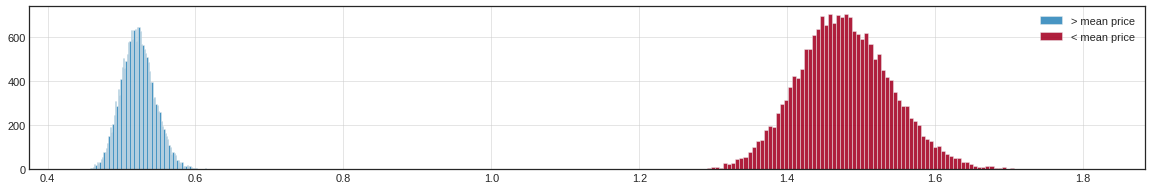

In [65]:
plt.rc('figure', figsize=(20,3))    
plt.hist(above_mean_samples, bins=100, alpha=0.9, label='> mean price');
plt.hist(below_mean_samples, bins=100, alpha=0.9, label='< mean price');
plt.legend();
plt.grid()
plt.show()
plt.close()

*Действительно, распределения нормальные. Теперь к ним уже можно применить доверительные интервалы.*

In [66]:
import statsmodels.stats.api as sms #  Для доверительных интервалов.
cm = sms.CompareMeans(sms.DescrStatsW(below_mean_samples),
                      sms.DescrStatsW(above_mean_samples))
print(cm.tconfint_diff(alpha=0.05)) # Указываем явно уровень значимости p = 0.05

(0.9544945040620846, 0.9563619720170798)


*Таким образом получаем, что с вероятностью 0.95 можно утверждать, что среднее кол-во покупок дешевого товара больше среднего кол-ва покупок дорогого на значение, которое находится между числами 0.954 и 0.956.*

*То есть простыми словами, уверенно можно сказать, что средних спрос дешевых товаров превосходит средний спрос дорогих на 0.95 единиц.*

##**3 гипотеза: SNAP льготы не влияют на спрос продуктов категории FOODS.** 

*    *H0: В дни выплаты SNAP льготы, спрос на продукты питания субкатегории FOODS_1 не изменяется.*

*    *H0: В дни выплаты SNAP льготы, спрос на продукты питания субкатегории FOODS_2 
не изменяется.*

*    *H0: В дни выплаты SNAP льготы, спрос на продукты питания субкатегории FOODS_3 не изменяется.*

*В качестве штата выбирем Техас, так как из все остальных он имеет самый низкий уровень ВВП и мы предполагаем, что в штатах с высоким уровнем ВВП не так активно исползуют SNAP льготу.*

In [0]:
state_name = 'TX'
FOODS_1 = ['event_type_1', 'snap_'+state_name] + [id_dict[col] for col in id_dict.keys() if 'FOODS_1' in col and state_name in col]
FOODS_2 = ['event_type_1', 'snap_'+state_name] + [id_dict[col] for col in id_dict.keys() if 'FOODS_2' in col and state_name in col]
FOODS_3 = ['event_type_1', 'snap_'+state_name] + [id_dict[col] for col in id_dict.keys() if 'FOODS_3' in col and state_name in col]

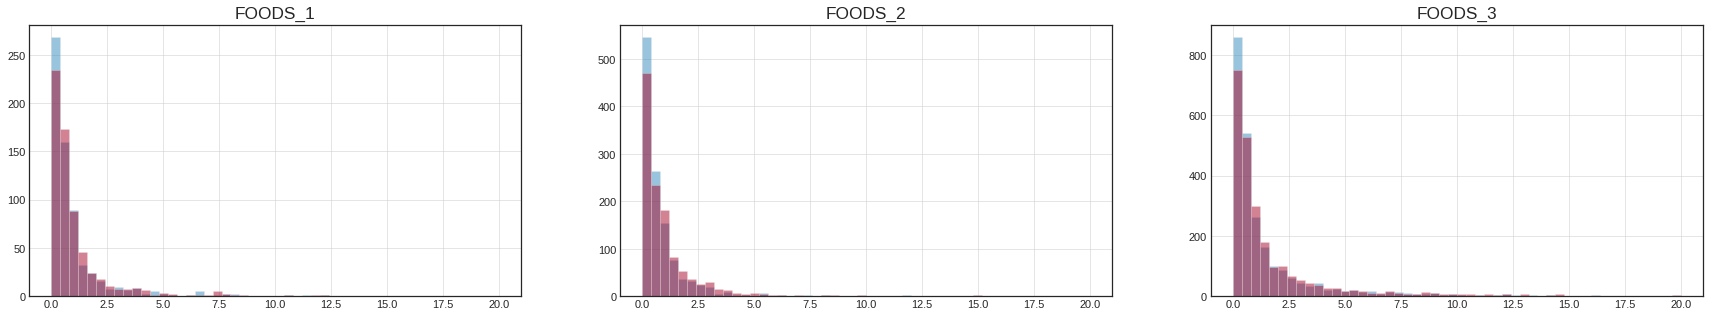

In [68]:
fig = plt.figure(figsize=(30,5))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

main_df.loc[:,FOODS_1].groupby('snap_'+state_name).mean().T.iloc[:,0].hist(bins=50, range=(0,20), alpha=0.5, label='without snap', ax=ax1)
main_df.loc[:,FOODS_1].groupby('snap_'+state_name).mean().T.iloc[:,1].hist(bins=50, range=(0,20), alpha=0.5, label='with snap', ax=ax1)
ax1.set_title('FOODS_1')

main_df.loc[:,FOODS_2].groupby('snap_'+state_name).mean().T.iloc[:,0].hist(bins=50, range=(0,20), alpha=0.5, label='without snap', ax=ax2)
main_df.loc[:,FOODS_2].groupby('snap_'+state_name).mean().T.iloc[:,1].hist(bins=50, range=(0,20), alpha=0.5, label='with snap', ax=ax2)
ax2.set_title('FOODS_2')

main_df.loc[:,FOODS_3].groupby('snap_'+state_name).mean().T.iloc[:,0].hist(bins=50, range=(0,20), alpha=0.5, label='without snap', ax=ax3)
main_df.loc[:,FOODS_3].groupby('snap_'+state_name).mean().T.iloc[:,1].hist(bins=50, range=(0,20), alpha=0.5, label='with snap', ax=ax3)
ax3.set_title('FOODS_3')

plt.show()
plt.close()

*Какмы видим, распределение далеко не напоминает нормальное, поэтому будем на этот раз использовать непараметрический, в частности проверим наши гипотезы H0 с помощью **двувыборочного критерия знаков для связных выборок** и **двувыборочного рангова критерия Уилкоксона**.*

*Предполагаем, что у той субкатегории, у которой будем самый уверенный прогноз критерия и будет той субкатегорией товаров, на которую и выделяются льготы, хотя и в действительности может произойти так, что при выпалате SNAP'а начнет уменьшаться спрос на другие субкатегории, поэтмоу мы установим лишь факт наличия или отсутсвия изменения, характер именения точно мы установить с помощью **критерия знаков** мы не сможем, но в последствии измерим среднии значения, чтобы попытаться всё-таки ответить, на какую из субкатегорий товаров распространяются льготы SNAP и какая всё-таки представляет из себя субкатегорию рядов продуктов питания.*

In [0]:
without_snap_1 = main_df.loc[:,FOODS_1].groupby('snap_'+state_name).mean().T.iloc[:,0].to_numpy()
with_snap_1    = main_df.loc[:,FOODS_1].groupby('snap_'+state_name).mean().T.iloc[:,1].to_numpy()

without_snap_2 = main_df.loc[:,FOODS_2].groupby('snap_'+state_name).mean().T.iloc[:,0].to_numpy()
with_snap_2    = main_df.loc[:,FOODS_2].groupby('snap_'+state_name).mean().T.iloc[:,1].to_numpy()

without_snap_3 = main_df.loc[:,FOODS_3].groupby('snap_'+state_name).mean().T.iloc[:,0].to_numpy()
with_snap_3    = main_df.loc[:,FOODS_3].groupby('snap_'+state_name).mean().T.iloc[:,1].to_numpy()

In [70]:
# Двухвыборочный критерий знаков для связных выборок.

from statsmodels.stats.descriptivestats import sign_test

_, p_FOODS_1 = sign_test(without_snap_1, np.median(with_snap_1))
_, p_FOODS_2 = sign_test(without_snap_2, np.median(with_snap_2))
_, p_FOODS_3 = sign_test(without_snap_3, np.median(with_snap_3))

print('Вероятность ошибочно отвергнуть верную гипотезу HO для FOODS_1 равна %.2f, с уровнем значимости p = 0.05'   % p_FOODS_1)
print('Вероятность ошибочно отвергнуть верную гипотезу HO для FOODS_2 равна %.2f, с уровнем значимости p = 0.05'   % p_FOODS_2)
print('Вероятность ошибочно отвергнуть верную гипотезу HO для FOODS_3 равна %.2f, с уровнем значимости p = 0.05\n' % p_FOODS_3)

print('p_FOODS_1 = ', p_FOODS_1)
print('p_FOODS_2 = ', p_FOODS_2)
print('p_FOODS_3 = ', p_FOODS_3)

Вероятность ошибочно отвергнуть верную гипотезу HO для FOODS_1 равна 0.22, с уровнем значимости p = 0.05
Вероятность ошибочно отвергнуть верную гипотезу HO для FOODS_2 равна 0.00, с уровнем значимости p = 0.05
Вероятность ошибочно отвергнуть верную гипотезу HO для FOODS_3 равна 0.00, с уровнем значимости p = 0.05

p_FOODS_1 =  0.2232732184605964
p_FOODS_2 =  9.267375982959642e-06
p_FOODS_3 =  8.906171340005577e-07


In [71]:
# Двухвыборочный рагновый критерий для связных выборок.

_, p_FOODS_1 = stats.wilcoxon(without_snap_1, with_snap_1)
_, p_FOODS_2 = stats.wilcoxon(without_snap_2, with_snap_2)
_, p_FOODS_3 = stats.wilcoxon(without_snap_3, with_snap_3)

print('Вероятность ошибочно отвергнуть верную гипотезу HO для FOODS_1 равна %.2f, с уровнем значимости p = 0.05'   % p_FOODS_1)
print('Вероятность ошибочно отвергнуть верную гипотезу HO для FOODS_2 равна %.2f, с уровнем значимости p = 0.05'   % p_FOODS_2)
print('Вероятность ошибочно отвергнуть верную гипотезу HO для FOODS_3 равна %.2f, с уровнем значимости p = 0.05\n' % p_FOODS_3)

print('p_FOODS_1 = ', p_FOODS_1)
print('p_FOODS_2 = ', p_FOODS_2)
print('p_FOODS_3 = ', p_FOODS_3)

Вероятность ошибочно отвергнуть верную гипотезу HO для FOODS_1 равна 0.00, с уровнем значимости p = 0.05
Вероятность ошибочно отвергнуть верную гипотезу HO для FOODS_2 равна 0.00, с уровнем значимости p = 0.05
Вероятность ошибочно отвергнуть верную гипотезу HO для FOODS_3 равна 0.00, с уровнем значимости p = 0.05

p_FOODS_1 =  1.812238159894697e-62
p_FOODS_2 =  4.9306922217084414e-182
p_FOODS_3 =  0.0


*В качестве результата получаем, что H0 гипотезы об FOODS_2 и FOODS_3 достаточно уверенно отвергаются в пользу альтернативной, а H0 гипотеза об FOODS_1 не может быть отвергнута знаковым критерием, то есть выплаты SNAP изменяют спрос на субкатегории FOODS_2 и FOODS_3, однако не изменяют его на FOODS_1, таким образом мы устанавливаем связь того, что вылпаты SNAP распространяются на одну из субкатегорий FOODS_2 или FOODS_3, предположительно на ту, спрос которой стал выше, давайте попытаемся определить на какую из них все-таки спрос в среднем стал выше, а на какую ниже или может быть выплаты влияют таким обарзом, что спрос одновременно возрастает или одновременно падает.*

In [0]:
without_snap_1_samples = []
with_snap_1_samples    = []

without_snap_2_samples = []
with_snap_2_samples    = []

without_snap_3_samples = []
with_snap_3_samples    = []

for _ in range(20000):
  bootstrap_sample = np.random.choice(without_snap_1, without_snap_1.shape[0])
  without_snap_1_samples.append(np.mean(bootstrap_sample))
  
  bootstrap_sample = np.random.choice(with_snap_1, with_snap_1.shape[0])
  with_snap_1_samples.append(np.mean(bootstrap_sample))

  bootstrap_sample = np.random.choice(without_snap_2, without_snap_2.shape[0])
  without_snap_2_samples.append(np.mean(bootstrap_sample))
  
  bootstrap_sample = np.random.choice(with_snap_2, with_snap_2.shape[0])
  with_snap_2_samples.append(np.mean(bootstrap_sample))

  bootstrap_sample = np.random.choice(without_snap_3, without_snap_3.shape[0])
  without_snap_3_samples.append(np.mean(bootstrap_sample))
  
  bootstrap_sample = np.random.choice(with_snap_3, with_snap_3.shape[0])
  with_snap_3_samples.append(np.mean(bootstrap_sample))

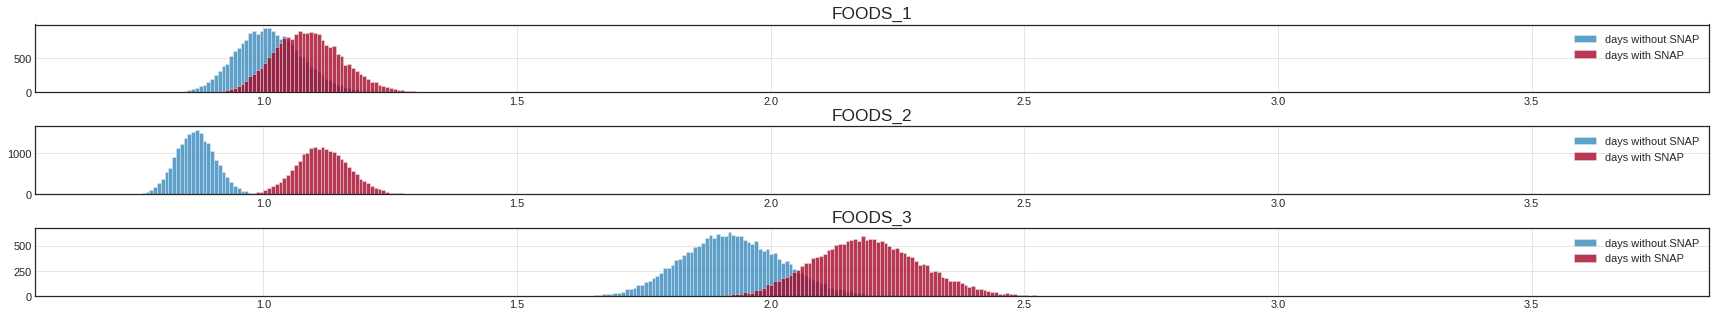

In [73]:
fig = plt.figure(figsize=(30,5))    
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax1.hist(without_snap_1_samples, bins=400, alpha=0.8, label='days without SNAP', range=(0.7,3.7));
ax1.hist(with_snap_1_samples,    bins=400, alpha=0.8, label='days with SNAP',    range=(0.7,3.7));
ax1.grid()
ax1.legend()
ax1.set_title('FOODS_1')

ax2.hist(without_snap_2_samples, bins=400, alpha=0.8, label='days without SNAP', range=(0.7,3.7));
ax2.hist(with_snap_2_samples,    bins=400, alpha=0.8, label='days with SNAP',    range=(0.7,3.7));
ax2.grid()
ax2.legend()
ax2.set_title('FOODS_2')

ax3.hist(without_snap_3_samples, bins=400, alpha=0.8, label='days without SNAP', range=(0.7,3.7));
ax3.hist(with_snap_3_samples,    bins=400, alpha=0.8, label='days with SNAP',   range=(0.7,3.7));
ax3.grid()
ax3.legend()
ax3.set_title('FOODS_3')

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()
plt.close()

Видим нормальные распределения, для которых визуально кажется, что спрос стал выше для обеих субкатегорий, давайте с помощью **доверительных интервалов** получим точную количественную оценку изменений соответствующих спросов.

In [74]:
cm2 = sms.CompareMeans(sms.DescrStatsW(with_snap_2_samples),
                       sms.DescrStatsW(without_snap_2_samples))

cm3 = sms.CompareMeans(sms.DescrStatsW(with_snap_3_samples),
                       sms.DescrStatsW(without_snap_3_samples))

print("Доверительные интервалы для изменения средних FOODS_2: (%.3f, %.3f)" % cm2.tconfint_diff(alpha=0.05))
print("Среднии для FOODS_2: %.2f и %.2f без SNAP и с SNAP соответственно.\n" % (np.mean(without_snap_2_samples), np.mean(with_snap_2_samples)))

print("Доверительные интервалы для изменения средних FOODS_3: (%.3f, %.3f)" % cm3.tconfint_diff(alpha=0.05))
print("Среднии для FOODS_3: %.2f и %.2f без SNAP и с SNAP соответственно.\n" % (np.mean(without_snap_3_samples), np.mean(with_snap_3_samples)))

print('Средний спрос на товары субкатегории FOODS_1: %.2f' % mean_time_series('FOODS_1', state_name).mean())

Доверительные интервалы для изменения средних FOODS_2: (0.250, 0.252)
Среднии для FOODS_2: 0.87 и 1.12 без SNAP и с SNAP соответственно.

Доверительные интервалы для изменения средних FOODS_3: (0.264, 0.268)
Среднии для FOODS_3: 1.92 и 2.19 без SNAP и с SNAP соответственно.

Средний спрос на товары субкатегории FOODS_1: 1.04


*То есть спрос поднялся на обе субкатегории товаров, с вероятностью 0.95 на 0.25 и 0.27 единиц соответсвенно.*

*Давайте перед тем как сделть заключительный вывод посмотрим еще на среднии цены товаров по субкатегориям:*

In [0]:
for FOODS_id in ['FOODS_1', 'FOODS_2', 'FOODS_3']:
  mean_price = price_sales_df.loc[list(filter(lambda x: x[:7] == FOODS_id, list(price_sales_df.reset_index().item_id.to_numpy())))]['sell_price'].mean()
  print('Средняя цена на товары субкатегории', FOODS_id, ': %.2f$' % mean_price)

Средняя цена на товары субкатегории FOODS_1 : 3.33$
Средняя цена на товары субкатегории FOODS_2 : 4.15$
Средняя цена на товары субкатегории FOODS_3 : 2.87$


**Вывод:**

*    *FOODS_1: ср. цена 3.33$, спрос составляет 1.0 единиц, не изменяется.*

*    *FOODS_2: ср. цена 4.15$, спрос вырос с 0.87 до 1.12.*

*    *FOODS_3: ср. цена 2.87$, спрос вырос с 1.92 до 2.19.*

*Таким образом можно достаточно уверенно можно сказать, что товары субкатегории FOODS_3 являются товарами рядовых продуктов, т.е. хлеб, мясо, яблоки и тому подобные вещи, которые мы едим каждый день и которые обладают самой низкой средней стоимостью.*

*Очень вероятно, что в реестр продуктов SNAP включены продукты из категории FOODS_2, т.к. спрос на них заметно выростает, причем можно заметить что именно эта субкатегория обладает большей стоимостью, это можно попытаться обосновать тем, что люди, не обладающее достатком, приходят в магазин и пользуются льготами покупают за счёт льгот дорогие продукты, а за свои средства покупают более дешевые, которые и покупают во время обычных походов в магазин.*

*Товары субкатегории FOODS_1 обладают средней ценой и средним спросом, причем выплаты SNAP на них вероятнее всего не распространяются, скорей это товары алкогольной продукции, может быть какие-нибудь снеки или что-то в этом роде, что покупается и употребляется в стандартном рижиме и приносит магазину стабильный, средний доход, возможно стоит проверить корреляцию спроса на товар и праздники, чтобы сделать более обоснованные выводы.*

##**Рассмотрим различные корреляции:**

*Попробуем посмотреть на различные наши столбцы в данных и найти те, что коррелирует достаточно сильно, может быть найдем что-нибудь интересное.*

*В выводе об результатов проверки третьей гипотезы мы пришли к тому, что субкатегория FOODS_1 требует дополнительного исследования, так что попробуем рассмотреть характер корреляции категории события выпавшего на день и величину спроса на товары субкатегории FOODS_1 в этот день.*

In [0]:
state_name = 'TX' # Чтобы исследования были корректны, рассмотрим штат Техас.
FOODS_1 = [id_dict[col] for col in id_dict.keys() if 'FOODS_1' in col and state_name in col]

In [0]:
tmp_df = main_df.loc[:,['event_type_1']]
tmp_df['mean_sales'] = main_df.loc[:,FOODS_1].mean(axis=1)
tmp_df = tmp_df.fillna('Ordinary')

In [77]:
tmp_df.groupby('event_type_1').mean()

,mean_sales
event_type_1,
Cultural,1.247928
National,0.858085
Ordinary,1.036444
Religious,1.088467
Sporting,1.053434


###**Топ-5 каких субкатегорий товаров чаще всего покупают вместе:**

*Рассмаотрим для всех 7 субкатегорий попарно значения корреляции Спирмена и отсортировав посмотрим на топ-5 из них.*

In [0]:
from itertools import combinations

corr_dict = {}

for subcat_names in list(combinations(subcat_df.columns[4:], 2)):
  cur_corr = stats.spearmanr(subcat_df[subcat_names[0]], subcat_df[subcat_names[-1]])
  corr_dict.update({cur_corr[0]: [subcat_names[0], subcat_names[1]]})

In [79]:
for idx, pair in enumerate(sorted(corr_dict.items(), key=lambda x: x[0], reverse=True)[:5]):
  print('Топ %.f:\t' % idx, pair[1][0], '\t', pair[1][1], '\tcorr: %.4f' % pair[0])

Топ 0:	 HOUSEHOLD_1 	 HOUSEHOLD_2 	corr: 0.8205
Топ 1:	 HOBBIES_1 	 HOUSEHOLD_2 	corr: 0.8059
Топ 2:	 FOODS_1 	 HOUSEHOLD_1 	corr: 0.7410
Топ 3:	 HOBBIES_1 	 HOUSEHOLD_1 	corr: 0.7183
Топ 4:	 FOODS_1 	 FOODS_3 	corr: 0.7128


In [80]:
for idx, pair in enumerate(sorted(corr_dict.items(), key=lambda x: x[0])[:5]):
  print('Топ -%.f:\t' % (idx+1), pair[1][0], '\t', pair[1][1], '\tcorr: %.4f' % pair[0])

Топ -1:	 FOODS_3 	 HOBBIES_2 	corr: 0.2931
Топ -2:	 HOBBIES_1 	 HOBBIES_2 	corr: 0.4747
Топ -3:	 FOODS_1 	 HOBBIES_2 	corr: 0.4832
Топ -4:	 FOODS_1 	 FOODS_2 	corr: 0.5085
Топ -5:	 FOODS_2 	 HOBBIES_2 	corr: 0.5117


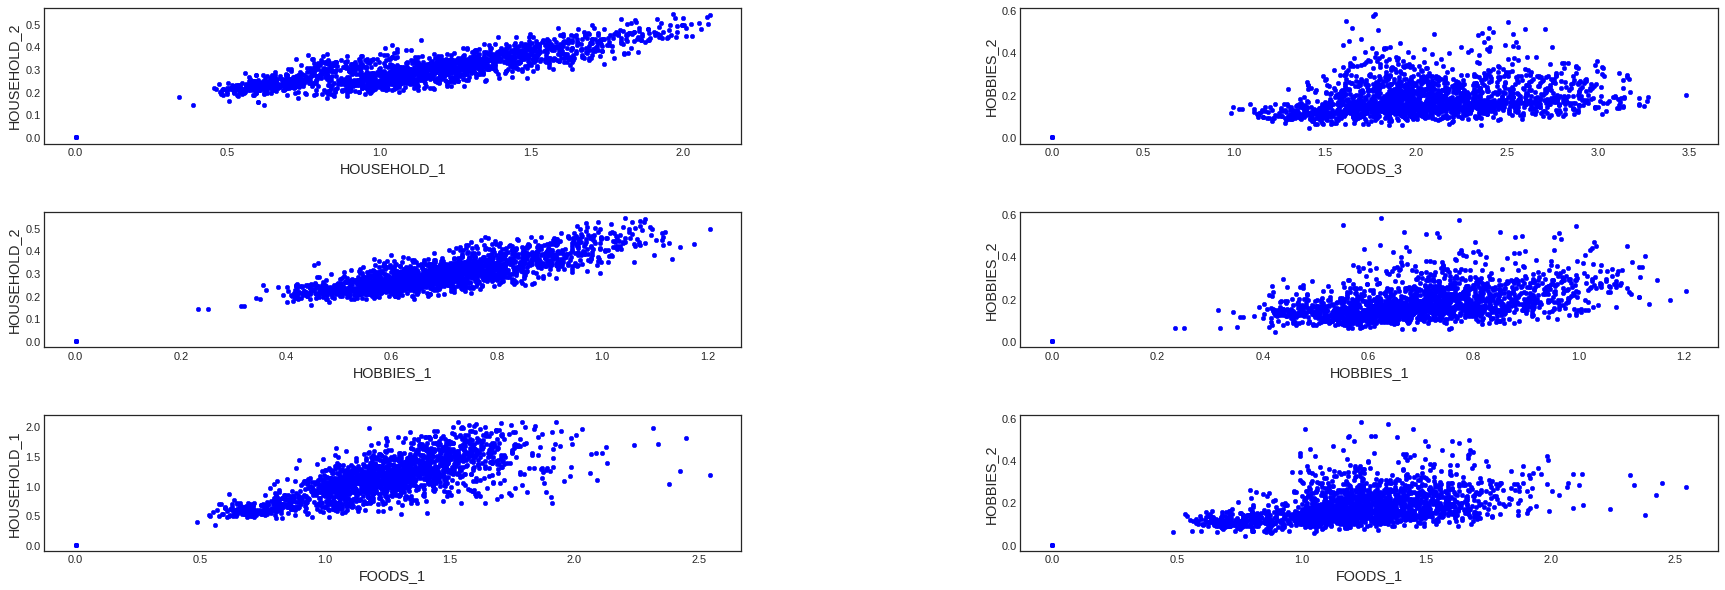

In [94]:
fig, axes = plt.subplots(3,2, figsize=(30,10))

subcat_df.plot.scatter(ax=axes[0,0], x='HOUSEHOLD_1', y='HOUSEHOLD_2')
subcat_df.plot.scatter(ax=axes[1,0], x='HOBBIES_1',   y='HOUSEHOLD_2')
subcat_df.plot.scatter(ax=axes[2,0], x='FOODS_1',     y='HOUSEHOLD_1')

subcat_df.plot.scatter(ax=axes[0,1], x='FOODS_3',     y='HOBBIES_2')
subcat_df.plot.scatter(ax=axes[1,1], x='HOBBIES_1',   y='HOBBIES_2')
subcat_df.plot.scatter(ax=axes[2,1], x='FOODS_1',     y='HOBBIES_2')

plt.subplots_adjust(wspace=0.4, hspace=0.5)

plt.show()
plt.close()

*То есть получаем вывод, что если в некоторый день выростает спрос у товаров субкатегории HOUSEHOLD_2 то и вместе с тем воззрастает и спрос у товаров HOUSHOLD_1, т.е. это говорит нам о том, что люди когда ходят в магазин, если берут товары категории HOUSEHOLD, то есть товары домашнего хозяйства, то скорей всего возьмут товары обеих субкатегорий, как следствие можно сделать вывод, то скорей всего стоит товары этих типов ставить рядом. Более точный прогноз можно было сделать, если бы рассматривать незвисимо чеки людей при покупаках и выявлять в них такого рода связи, в нашем случае мы, к сожалению, не обладаем такой инфорамцией.*

*И можно заметить, что товары для хобби редко берут с едой и в то же время, достаточно странно, продукты субкатегорий FOODS_1 и FOODS_2 берут редко, это еще одно подтверждение тому, что скорей всего FOODS_1 - это продукты алкогольной продукции, а FOODS_2 - повседневного питания, ведь действительно, кажется странным идти в магазин за бутылкой водки и при этом брать, яблоки с петрушкой.*

**Результат выше, вообще говоря, не достаточно стргогий, ведь мы усредняем спрос по дням, то есть мы говорим на самом деле следующее, если спрос на товар вот такой субкатегории измнился вот так, то скорей всего спрос на этот товар изменится так же. Соттветствующие выводы конечно имеют место быть, но все-таки  попробуем поддступиться к вопросу о корреляции покупок товаров более корректнее и рассмотрим попарные корреляции между всеми 3049 типами товаров:**

In [83]:
tmp_df = sales_df.drop(['id','dept_id','cat_id','store_id', 'state_id'], axis=1).groupby('item_id').mean().T
tmp_df

item_id,FOODS_1_001,FOODS_1_002,FOODS_1_003,FOODS_1_004,FOODS_1_005,FOODS_1_006,FOODS_1_008,FOODS_1_009,FOODS_1_010,FOODS_1_011,FOODS_1_012,FOODS_1_013,FOODS_1_014,FOODS_1_015,FOODS_1_016,FOODS_1_017,FOODS_1_018,FOODS_1_019,FOODS_1_020,FOODS_1_021,FOODS_1_022,FOODS_1_023,FOODS_1_024,FOODS_1_025,FOODS_1_026,FOODS_1_027,FOODS_1_028,FOODS_1_029,FOODS_1_030,FOODS_1_031,FOODS_1_032,FOODS_1_033,FOODS_1_034,FOODS_1_035,FOODS_1_036,FOODS_1_037,FOODS_1_038,FOODS_1_039,FOODS_1_040,FOODS_1_041,...,HOUSEHOLD_2_477,HOUSEHOLD_2_478,HOUSEHOLD_2_479,HOUSEHOLD_2_480,HOUSEHOLD_2_481,HOUSEHOLD_2_482,HOUSEHOLD_2_483,HOUSEHOLD_2_484,HOUSEHOLD_2_485,HOUSEHOLD_2_486,HOUSEHOLD_2_487,HOUSEHOLD_2_488,HOUSEHOLD_2_489,HOUSEHOLD_2_490,HOUSEHOLD_2_491,HOUSEHOLD_2_492,HOUSEHOLD_2_493,HOUSEHOLD_2_494,HOUSEHOLD_2_495,HOUSEHOLD_2_496,HOUSEHOLD_2_497,HOUSEHOLD_2_498,HOUSEHOLD_2_499,HOUSEHOLD_2_500,HOUSEHOLD_2_501,HOUSEHOLD_2_502,HOUSEHOLD_2_503,HOUSEHOLD_2_504,HOUSEHOLD_2_505,HOUSEHOLD_2_506,HOUSEHOLD_2_507,HOUSEHOLD_2_508,HOUSEHOLD_2_509,HOUSEHOLD_2_510,HOUSEHOLD_2_511,HOUSEHOLD_2_512,HOUSEHOLD_2_513,HOUSEHOLD_2_514,HOUSEHOLD_2_515,HOUSEHOLD_2_516
d_1,0.6,0.4,1.4,0.0,3.4,1.6,0.0,0.0,0.0,0.7,0.0,0.8,0.0,0.0,1.3,0.0,4.7,10.6,1.4,0.0,0.0,0.0,3.0,0.0,0.6,0.0,0.0,0.0,0.2,2.2,6.2,0.0,0.0,0.7,3.3,0.5,0.0,0.0,2.3,1.6,...,0.0,0.0,0.0,0.4,0.3,0.0,0.7,0.0,0.5,0.6,0.0,0.4,0.0,0.0,0.0,0.6,0.0,0.2,1.3,0.0,0.8,0.0,0.0,0.0,0.0,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.8,0.0,2.0,0.5,0.0,0.4,0.0,0.2
d_2,0.6,0.5,0.8,0.0,3.2,0.9,0.0,0.0,0.0,0.1,0.0,0.9,0.0,0.0,0.5,0.0,2.6,10.4,2.2,0.0,0.0,0.0,2.8,0.0,0.7,0.0,0.0,0.0,0.0,2.1,6.3,0.0,0.0,1.2,2.3,0.4,0.0,0.0,3.8,1.7,...,0.0,0.0,0.0,0.2,0.3,0.0,1.3,0.0,0.5,0.4,0.0,0.6,0.0,0.0,0.0,1.5,0.0,0.3,1.0,0.0,0.6,0.0,0.0,0.0,0.0,0.1,0.4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.4,0.4,0.0,0.8,0.0,0.4
d_3,0.4,0.7,0.3,0.0,1.3,2.0,0.0,0.0,0.0,0.5,0.0,2.0,0.0,0.0,0.0,0.0,3.0,4.7,2.1,0.0,0.0,0.0,2.2,0.0,0.7,0.0,0.0,0.0,0.1,1.4,3.4,0.0,0.0,0.8,1.3,0.1,0.0,0.0,1.7,1.3,...,0.0,0.0,0.0,0.1,0.1,0.0,1.2,0.0,0.4,0.1,0.0,0.1,0.0,0.0,0.0,0.4,0.0,0.2,1.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,1.2,0.0,0.7,0.1,0.0,0.2,0.0,0.0
d_4,0.6,0.4,0.6,0.0,2.0,1.6,0.0,0.0,0.0,0.1,0.0,0.8,0.0,0.0,0.1,0.0,2.4,6.9,1.2,0.0,0.0,0.0,2.6,0.0,1.4,0.0,0.0,0.0,0.1,0.6,5.4,0.0,0.0,0.0,2.7,0.2,0.0,0.0,0.9,1.4,...,0.0,0.0,0.0,0.2,0.4,0.0,0.9,0.0,0.1,0.2,0.0,0.5,0.0,0.0,0.0,1.0,0.0,0.0,1.1,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.8,0.0,0.7,0.3,0.0,0.1,0.0,0.3
d_5,0.7,0.3,0.3,0.0,1.0,1.4,0.0,0.0,0.0,0.0,0.0,1.4,0.0,0.0,0.7,0.0,1.3,5.1,0.6,0.0,0.0,0.0,1.5,0.0,0.5,0.0,0.0,0.0,0.1,1.3,4.8,0.0,0.0,0.1,2.6,0.1,0.0,0.0,0.8,0.6,...,0.0,0.0,0.0,0.4,0.2,0.0,0.9,0.0,0.0,0.4,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.4,0.0,0.0,0.0,0.0,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.9,0.0,0.9,0.2,0.0,0.1,0.0,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d_1909,0.3,0.5,0.4,0.0,2.7,1.0,0.1,0.0,0.4,1.8,4.8,1.2,0.7,0.2,0.5,0.4,6.0,8.3,1.3,0.5,0.3,2.3,1.8,0.7,1.0,2.5,2.0,0.5,0.1,1.1,5.2,0.2,1.0,1.9,1.4,1.2,0.4,0.5,1.6,0.5,...,0.8,0.1,0.0,0.1,0.0,0.2,0.8,0.5,0.7,0.1,0.1,0.0,0.2,1.2,0.5,0.5,0.5,0.1,0.8,0.2,0.3,0.1,1.0,0.2,0.8,0.0,0.0,0.1,0.3,0.0,0.7,0.1,0.7,1.3,0.4,0.2,0.4,0.0,0.1,0.1
d_1910,0.6,0.5,0.4,0.0,1.2,0.4,0.1,0.0,0.4,1.0,7.8,1.9,1.3,0.6,0.4,0.9,8.7,3.9,1.0,1.1,0.2,2.2,0.6,0.1,1.0,2.6,1.4,0.5,0.8,0.7,5.0,0.1,0.9,0.9,1.3,1.0,0.4,0.2,0.8,0.8,...,0.9,0.0,0.3,0.5,0.0,0.0,1.0,0.1,0.1,0.3,0.1,0.3,0.0,1.4,0.3,0.2,0.1,0.0,1.2,0.3,0.2,0.4,1.7,0.4,0.7,0.0,0.2,0.0,0.1,0.2,0.3,0.0,0.8,1.4,0.2,0.8,0.6,0.0,0.1,0.2
d_1911,0.2,0.3,0.3,0.0,1.5,1.4,0.1,0.0,0.6,0.9,7.1,1.2,0.3,0.4,0.5,0.6,14.2,3.5,1.4,0.7,0.2,3.8,0.8,0.7,1.4,2.4,1.7,0.3,0.9,0.9,6.2,0.3,0.8,1.4,1.6,1.2,0.8,0.2,1.5,1.0,...,1.3,0.3,0.1,0.2,0.4,0.3,1.0,0.2,0.2,0.3,0.3,0.1,0.1,2.0,0.8,0.6,

In [84]:
corr_dict = {}

items = list(combinations(tmp_df.columns, 2))

for id_ in tqdm(np.random.randint(0, len(items), 100000)):

  item_names = items[id_]
  cur_corr = stats.spearmanr(tmp_df[item_names[0]], tmp_df[item_names[-1]])
  corr_dict.update({cur_corr[0]: [item_names[0], item_names[1]]})

In [85]:
sorted_dict = sorted(corr_dict.items(), key=lambda x: x[0], reverse=True)
for idx, pair in enumerate(sorted_dict[:5]):
  print('Топ %.f:\t' % idx, pair[1][0], '\t', pair[1][1], '\tcorr: %.4f' % pair[0])
plus_one = [sorted_dict[0][1][0], sorted_dict[0][1][1]]

Топ 0:	 FOODS_3_047 	 FOODS_3_166 	corr: 0.9815
Топ 1:	 FOODS_3_038 	 FOODS_3_119 	corr: 0.9636
Топ 2:	 HOUSEHOLD_1_098 	 HOUSEHOLD_1_371 	corr: 0.9513
Топ 3:	 FOODS_2_050 	 HOUSEHOLD_2_490 	corr: 0.9475
Топ 4:	 FOODS_3_044 	 FOODS_3_105 	corr: 0.9455


In [86]:
sorted_dict = sorted(corr_dict.items(), key=lambda x: x[0])
for idx, pair in enumerate(sorted_dict[:5]):
  print('Топ %.f:\t' % idx, pair[1][0], '\t', pair[1][1], '\tcorr: %.4f' % pair[0])
minus_one = [sorted_dict[0][1][0], sorted_dict[0][1][1]]

Топ 0:	 FOODS_3_732 	 HOUSEHOLD_1_102 	corr: -0.7481
Топ 1:	 FOODS_3_468 	 HOUSEHOLD_1_024 	corr: -0.7208
Топ 2:	 FOODS_3_640 	 FOODS_3_732 	corr: -0.7138
Топ 3:	 FOODS_2_379 	 FOODS_3_732 	corr: -0.7120
Топ 4:	 FOODS_3_054 	 HOUSEHOLD_2_493 	corr: -0.7118


In [87]:
sorted_dict = sorted(corr_dict.items(), key=lambda x: x[0]**2)
for idx, pair in enumerate(sorted_dict[:5]):
  print('Топ %.f:\t' % idx, pair[1][0], '\t', pair[1][1], '\tcorr: %.4f' % pair[0])
zero_one = [sorted_dict[0][1][0], sorted_dict[0][1][1]]

Топ 0:	 FOODS_1_117 	 HOBBIES_1_381 	corr: 0.0000
Топ 1:	 FOODS_3_570 	 FOODS_3_774 	corr: 0.0000
Топ 2:	 FOODS_2_289 	 HOBBIES_1_299 	corr: 0.0000
Топ 3:	 FOODS_3_184 	 FOODS_3_723 	corr: -0.0000
Топ 4:	 HOBBIES_1_150 	 HOUSEHOLD_2_206 	corr: -0.0000


**Заметим, что близкая к +1 корреляция наблюдается приймущественно у товаров одной субкатегории, близкая к -1 и к 0 уже в основном у товаров разных субкатегорий.**

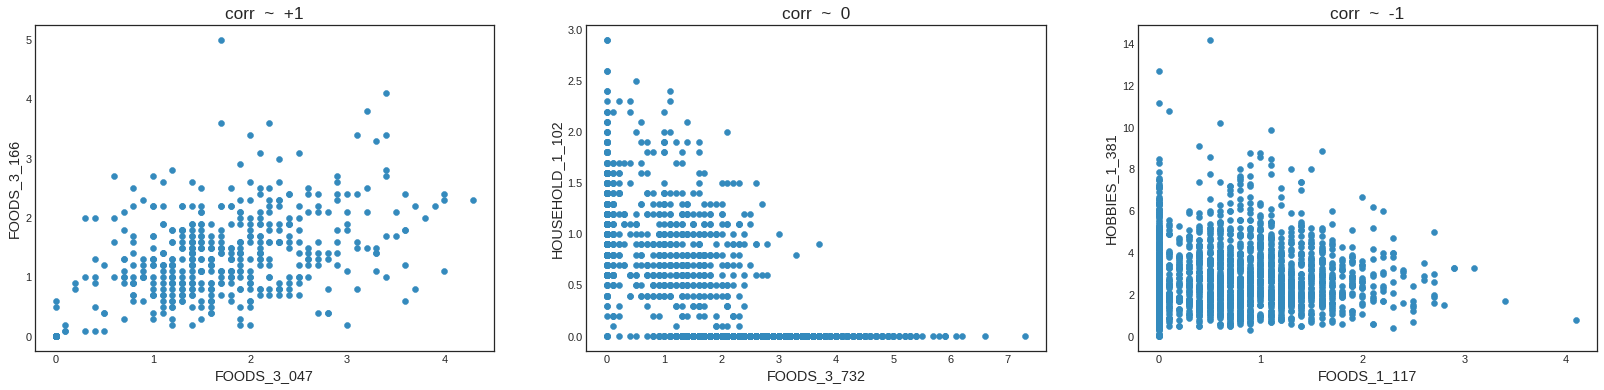

In [88]:
fig = plt.figure(figsize=(28,6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.scatter(x=tmp_df[plus_one[0]], y=tmp_df[plus_one[1]])
ax1.set_xlabel(plus_one[0])
ax1.set_ylabel(plus_one[1])
ax1.set_title('corr  ~  +1')

ax2.scatter(x=tmp_df[minus_one[0]], y=tmp_df[minus_one[1]])
ax2.set_xlabel(minus_one[0])
ax2.set_ylabel(minus_one[1])
ax2.set_title('corr  ~  0')

ax3.scatter(x=tmp_df[zero_one[0]], y=tmp_df[zero_one[1]])
ax3.set_xlabel(zero_one[0])
ax3.set_ylabel(zero_one[1])
ax3.set_title('corr  ~  -1')

plt.show()
plt.close()

Как видим, у нас достаточно интересная корреляция:
*    Корреляция спроса, близкая к +1.0, некоторой пары предметов, говорит нам о том, что очень часто когда люди покупают один тип товаров, то они и вместе с тем берут и второй.
*    Кореляция спроса, близкая к -1.0, некоторой пары товаров, говорит нам о том, что когда в магазинах берут один из пары товаров, то второй практически никогда не берут. То есть это товары в каком-то смысле исключают друг друга с точки зерния спроса потребителя, характер исключения может быть разный, с одной стороны это может проявляться к примеру тем, что редко кто покупает допустим спортивное питание и алкоголь -  спортсмены обычно не пьют, или допустим два разных типа мяса - если я взял кило свинины, зачем мне брать еще кило говядины, возьму ее в следующий раз.
*    Корреляция спроса, близкая по модулю к 0.0, говорит нам о том, что нет никакой линейной связи между уровнем спроса на товар в случае покупки одного из товаров из пары, т.е. в достаточнй степени не известно, если я взял зубную щётку, возьму ли я батарейки для пульта.

###**Уровень корреляции между выплатами SNAP:**

*Посмотрим какой уровень корреляции между бинарными значениями выплат SNAP по штатам, то есть насколько сильный характер частоты совпадения выплат SNAP в разных штатах в один и тот же день. В качестве меры кэтой линейной зависимости будем брать* **корреляцию Мэтьюса**.


In [89]:
subcat_df.loc[:,['snap_CA','snap_TX','snap_WI']]

,snap_CA,snap_TX,snap_WI
date,,,
2011-01-29,0,0,0
2011-01-30,0,0,0
2011-01-31,0,0,0
2011-02-01,1,1,0
2011-02-02,1,0,1
...,...,...,...
2016-04-20,0,0,0
2016-04-21,0,0,0
2016-04-22,0,0,0


In [0]:
tmp = subcat_df.loc[:,['snap_CA','snap_TX','snap_WI']].to_numpy()
snap_dict = {'CA': tmp[:,0], 'TX': tmp[:,1], 'WI': tmp[:,2]}

In [0]:
from sklearn.metrics import matthews_corrcoef

corr_CA_TX = matthews_corrcoef(snap_dict['CA'], snap_dict['TX'])
corr_TX_WI = matthews_corrcoef(snap_dict['WI'], snap_dict['TX'])
corr_WI_CA = matthews_corrcoef(snap_dict['CA'], snap_dict['WI'])

In [92]:
print('Уровень корреляции между выплатами SNAP в Калифорнии и Техасе     =\t%.4f' % corr_CA_TX)
print('Уровень корреляции между выплатами SNAP в Техасе и Висконсине     =\t%.4f' % corr_TX_WI)
print('Уровень корреляции между выплатами SNAP в Висконсине и Калифорнии =\t%.4f' % corr_WI_CA)

Уровень корреляции между выплатами SNAP в Калифорнии и Техасе     =	0.4036
Уровень корреляции между выплатами SNAP в Техасе и Висконсине     =	0.5527
Уровень корреляции между выплатами SNAP в Висконсине и Калифорнии =	0.4036


In [93]:
print(stats.chi2_contingency(snap_dict['CA']+1, snap_dict['TX']+1))
print(stats.chi2_contingency(snap_dict['WI']+1, snap_dict['TX']+1))
print(stats.chi2_contingency(snap_dict['CA']+1, snap_dict['WI']+1))

(0.0, 1.0, 0, array([1., 1., 1., ..., 1., 1., 1.]))
(0.0, 1.0, 0, array([1., 1., 1., ..., 1., 1., 1.]))
(0.0, 1.0, 0, array([1., 1., 1., ..., 1., 1., 1.]))


*Таким образом видим, что присутствует ничтожная корреляция, причем даже у Техаса с Висконсином она довольно выше, чем у других пар, однако всё равно значения корреляций слишком мало, чтобы можно говорить о какой-либо линейной зависимости, это формально подтверждает критерий Хи-квадрат.*

**Вывод:** *Snap выплаты штатами своему населению происходит исходя сугубо из соображений внутри штатов и никаких особых связей внутригосударственных не наблюдается, а не нулевая корреляция объясняется тем, что кол-во выплат в месяц происходит ровно 10, поэтому, вообще говоря, нулевая корреляция невозможна, и никакой связи на уровне законов или указов об обязательстве штатов выпалчивтаь SNAP в определенном порядке, практически навярняка отсутствует.*

#***6 этап. Предсказание временного ряда и отправка решения на Kaggle:***

*На последнем содержательном шаге займемся самым интересным, спрогнозируем спрос на все наши товары и проверим наш результат на тестовой выборке на Kaggle.*

*Вместо того, чтобы сразу строить нечто сложное, начнем строить модели начиная с более легких вплоть до сложных.*

**План на этом шаге следующий:**
*    *Форматируем для начала наши данные - приведем их к каноническому виду. т.е. к такому, с которым все модели обработки временных рядов хорошо работают.*
*    *Напишем **baseline** - спрогнозируем все спросы исключительно из модели прогнозирования непрерывного временного ряда - тройного экспоненциального сглаживания, вероятно из спорадичного и дискретного распределения продаж модель очень плохо спрогнозирует, но для того, чтобы понять чего можно ожидать сойдет.*
*    *Используем **полносвязную нейронную сеть из нескольких слоев**, использующую лаги, собранные ранее статистики, значения корреляций и т.п. (На данный момент реализованно не до конца)*

##**0. Препарация данных.**

In [95]:
# Посмотрим на наш очень сырой, относительно работы с временными рядами, датасет.
main_df.head(2)

,event_type_1,snap_CA,snap_TX,snap_WI,_0,_1,_2,_3,_4,_5,_6,_7,_8,_9,_10,_11,_12,_13,_14,_15,_16,_17,_18,_19,_20,_21,_22,_23,_24,_25,_26,_27,_28,_29,_30,_31,_32,_33,_34,_35,...,_30450,_30451,_30452,_30453,_30454,_30455,_30456,_30457,_30458,_30459,_30460,_30461,_30462,_30463,_30464,_30465,_30466,_30467,_30468,_30469,_30470,_30471,_30472,_30473,_30474,_30475,_30476,_30477,_30478,_30479,_30480,_30481,_30482,_30483,_30484,_30485,_30486,_30487,_30488,_30489
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-29,NaN,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,9.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,16.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,14.0,0.0,0.0,7.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
2011-01-30,NaN,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,12.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.0,0.0,0.0,7.0,0.0,0.0,6.0,13.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,11.0,1.0,0.0,4.0,0.0,0.0,6.0,0.0,0.0


In [96]:
# Уберем не нужные ранговые стобцы.
date_df = main_df.drop(['event_type_1', 'snap_CA', 'snap_TX', 'snap_WI'], axis=1).reset_index()
date_df.head(2)

,date,_0,_1,_2,_3,_4,_5,_6,_7,_8,_9,_10,_11,_12,_13,_14,_15,_16,_17,_18,_19,_20,_21,_22,_23,_24,_25,_26,_27,_28,_29,_30,_31,_32,_33,_34,_35,_36,_37,_38,...,_30450,_30451,_30452,_30453,_30454,_30455,_30456,_30457,_30458,_30459,_30460,_30461,_30462,_30463,_30464,_30465,_30466,_30467,_30468,_30469,_30470,_30471,_30472,_30473,_30474,_30475,_30476,_30477,_30478,_30479,_30480,_30481,_30482,_30483,_30484,_30485,_30486,_30487,_30488,_30489
0,2011-01-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,9.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,16.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,14.0,0.0,0.0,7.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
1,2011-01-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,12.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.0,0.0,0.0,7.0,0.0,0.0,6.0,13.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,11.0,1.0,0.0,4.0,0.0,0.0,6.0,0.0,0.0


In [97]:
date_df['Datetime'] = pd.to_datetime(date_df.date, format='%Y-%m-%d %H:%M:%S')
date_df.index  = date_df.Datetime
date_df.drop(['date', 'Datetime'], axis = 1, inplace = True)
date_df.head(2)

,_0,_1,_2,_3,_4,_5,_6,_7,_8,_9,_10,_11,_12,_13,_14,_15,_16,_17,_18,_19,_20,_21,_22,_23,_24,_25,_26,_27,_28,_29,_30,_31,_32,_33,_34,_35,_36,_37,_38,_39,...,_30450,_30451,_30452,_30453,_30454,_30455,_30456,_30457,_30458,_30459,_30460,_30461,_30462,_30463,_30464,_30465,_30466,_30467,_30468,_30469,_30470,_30471,_30472,_30473,_30474,_30475,_30476,_30477,_30478,_30479,_30480,_30481,_30482,_30483,_30484,_30485,_30486,_30487,_30488,_30489
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,9.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,16.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,14.0,0.0,0.0,7.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
2011-01-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,12.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.0,0.0,0.0,7.0,0.0,0.0,6.0,13.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,11.0,1.0,0.0,4.0,0.0,0.0,6.0,0.0,0.0


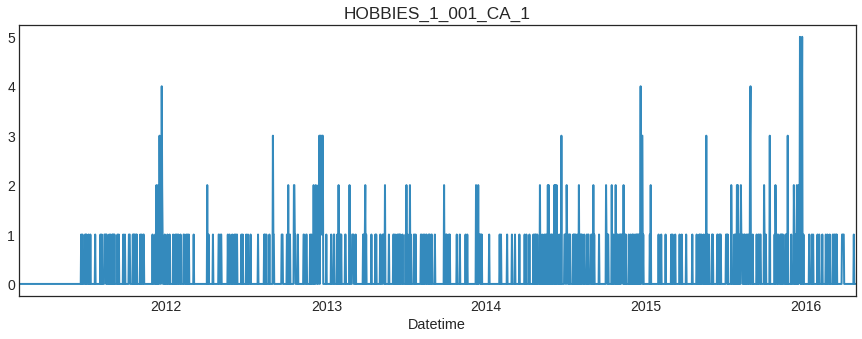

In [98]:
id_='_1'
date_df[id_].plot(figsize=(15,5), title=name_id['_0'], fontsize=14);

*Мы уже это замечали, но все равно оговорим, наши скачки дискретны, и они временной ряд имеет достаточно специфичный вид:*

*    Смена значений происходит дискретно, т.е. как мы знаем, знаениями рядов являются числа, которые говорят о том, сколько купят единиц товара в конкретный день, а купить не моугт 0.33 шкафа, поэтмоу любые дельта - целые.
*   Опять же, в силу формулировки задачи, известно, что спрос зачастаю равен 0 и ниже не может быть.

**Из всего это следует, что привычного для нас тренда, в этих рядах нету.**

###**1. Тренд.**

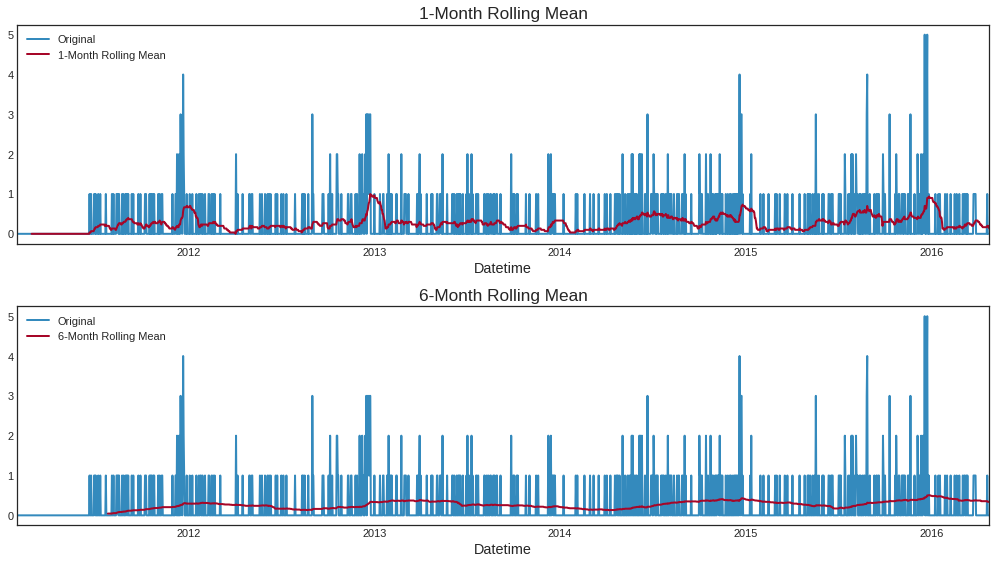

In [99]:
fig, axes = plt.subplots(2, 1, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(8)

window = 30
date_df[id_].plot(ax=axes[0], label='Original')
date_df[id_].rolling(window=window).mean().plot(ax=axes[0], label='1-Month Rolling Mean')
axes[0].set_title("1-Month Rolling Mean")
axes[0].legend(loc='best')

window = 30*6
date_df[id_].plot(ax=axes[1], label='Original')
date_df[id_].rolling(window=window).mean().plot(ax=axes[1], label='6-Month Rolling Mean')
axes[1].set_title("6-Month Rolling Mean")
axes[1].legend(loc='best')

plt.tight_layout()
plt.show()

*Как мы еще раз видим, никакого смысла извлекать тренда нет, потому что он напротив будет мешать и создаст вещественные числа.*

###**2. Сезонность.**

In [100]:
plt.rcParams['figure.figsize'] = 20, 5
date_df['year']  = date_df.index.year
date_df['month'] = date_df.index.month
date_df['dow']   = date_df.index.dayofweek
date_df['day']   = date_df.index.day
date_df_pivot = pd.pivot_table(date_df.loc[:,[id_,'year', 'month','dow','day']], values = id_, columns = "year", index = "month")
date_df.loc[:,[id_,'year', 'month','dow', 'day']].head(2)

,_1,year,month,dow,day
Datetime,,,,,
2011-01-29,0.0,2011,1,5,29
2011-01-30,0.0,2011,1,6,30


In [101]:
date_df_pivot.head(2)

year,2011,2012,2013,2014,2015,2016
month,,,,,,
1,0.0,0.225806,0.258065,0.032258,0.129032,0.129032
2,0.0,0.206897,0.214286,0.107143,0.107143,0.172414


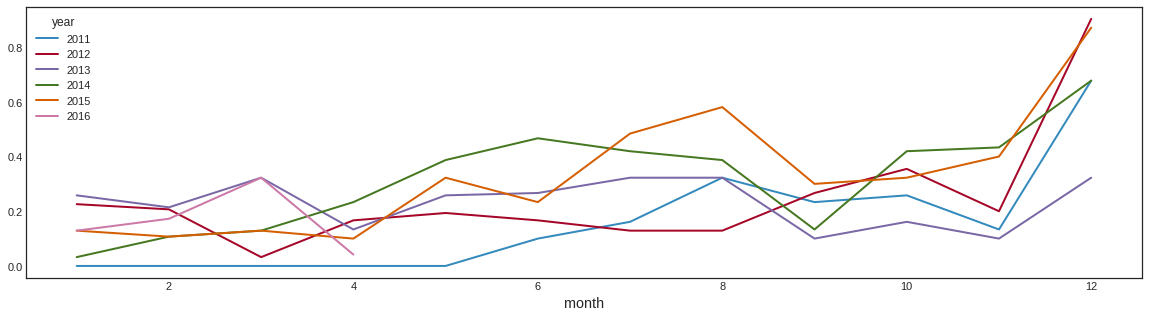

In [102]:
date_df_pivot.plot();

In [0]:
date_df.drop(['year','month','dow','day'], axis=1, inplace=True)

*Яркой сезонности нет, но что-то такое больше всего напоминает что-то структурированное, вначале меньше, вконце больше.*

###**STL-декопозиция ряда.**

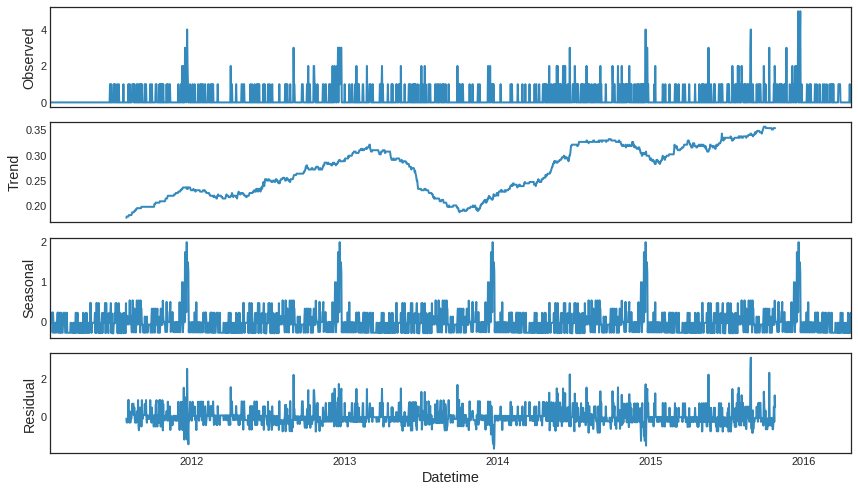

In [104]:
plt.rcParams['figure.figsize'] = 12, 7
result = sm.tsa.seasonal_decompose(date_df[id_], model='additive', freq=365)
result.plot()
plt.show()

*Очень красивые на самом деле тернд и сезонность, но если посмотреть на остатки, но можно увидеть, что ничего хорошего - остатки напоминают исходный ряд, только в нем теперь появились вещественные числа и пропала всякая дискретная структура, так тоже постпать нельзя, посмотрим, что будет, если использовать мультипликативную модель.*

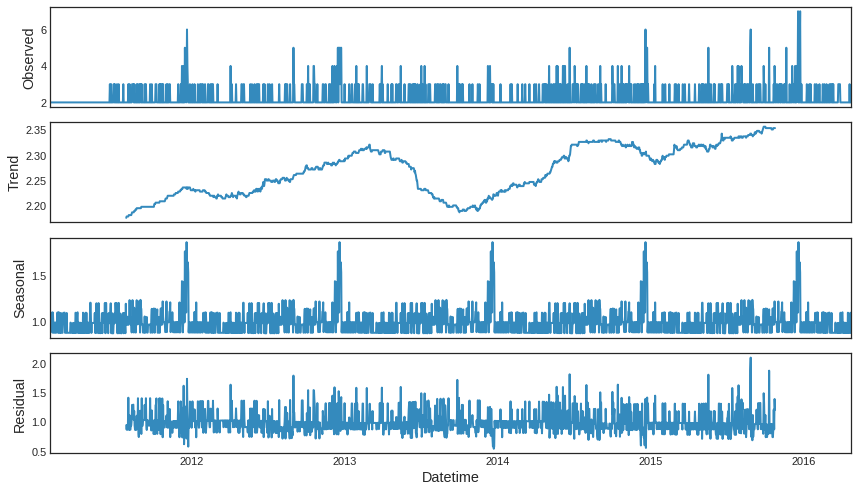

In [105]:
plt.rcParams['figure.figsize'] = 12, 7
date_df[id_]+=1
result = sm.tsa.seasonal_decompose(date_df[id_]+1, model='mul', freq= 365)
result.plot()
plt.show()

*Так, ну уже что-то в этом есть, хоть и далеко от чего стоящего, как минимум нам получилось остатки привести к разбросу в 1.*

###**Разберем, в качестве примера, этот ряд с помощью мультипликативной модели.**

Исходный временной ряд.

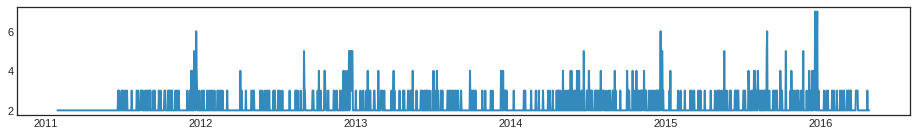

In [106]:
plt.figure(figsize=(16,2))
date_df[id_] += 1
plt.plot(date_df[id_])
plt.show()

Плавающее среднее.

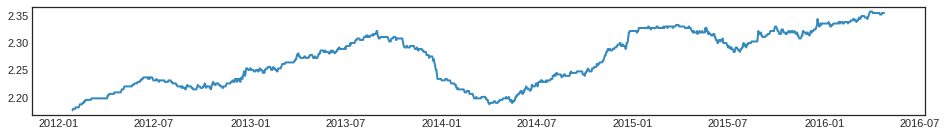

In [107]:
plt.figure(figsize=(16,2))

MA = date_df[id_].rolling(window=365).mean()

plt.plot(MA)
plt.show()

Убираем тренд.

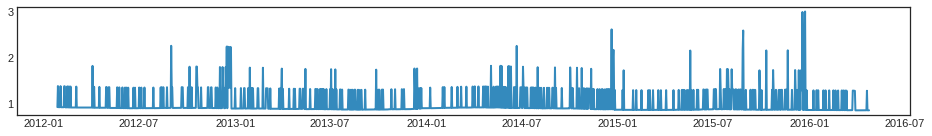

In [108]:
detrend_ = date_df[id_] / MA
plt.figure(figsize=(16,2))

plt.plot(detrend_)
plt.show()

Нормализуем по дням сезона.

In [0]:
def seasonal_mean(x, period):
    """
    Return means for each period in x. period is an int that gives the
    number of periods per cycle. E.g., 12 for monthly. NaNs are ignored
    in the mean.
    """
    return np.array([pd_nanmean(x[i::period], axis=0) for i in range(period)])

In [0]:
s_a = seasonal_mean(detrend_, 365)
#s_a -= np.mean(s_a, axis=0)

nobs = detrend_.shape[0]
seasonal = np.tile(s_a.T, nobs // 365 + 1).T[:nobs]

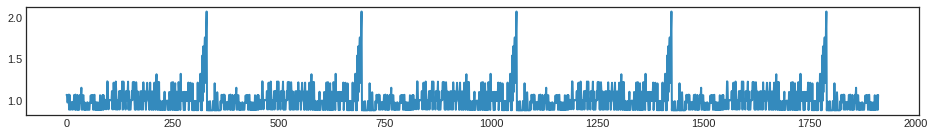

In [111]:
plt.figure(figsize=(16,2))

plt.plot(seasonal)
plt.show()

Остатки.

In [0]:
residuals = date_df[id_] / (MA * seasonal)

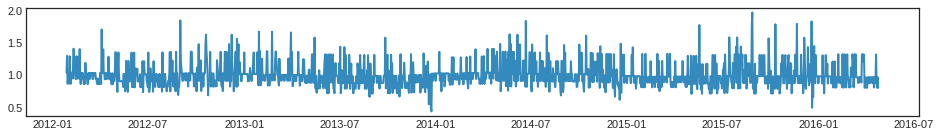

In [113]:
plt.figure(figsize=(16,2))

plt.plot(residuals)
plt.show()

**Сделаем предсказание по ряду.**

In [0]:
w_years = 365
train = date_df.loc[:,[id_]].iloc[:-w_years]
val   = date_df.loc[:,[id_]].iloc[-w_years:]

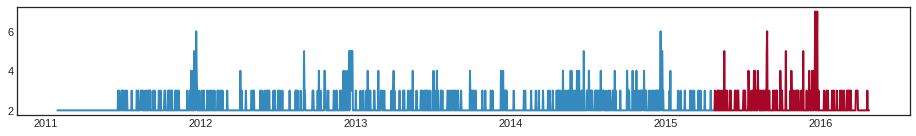

In [115]:
plt.figure(figsize=(16,2))

plt.plot(train[id_])
plt.plot(val[id_])

plt.show()

***Попробуем предсказать на один год вперед и провалидируемся.***

####**Прогноз средним.**

In [0]:
preds = [train[id_].mean()] * w_years

In [0]:
# Метрики качества:

from sklearn.metrics import mean_squared_error
from math import sqrt
    
def rmse(y_actual, y_predicted):
    rmse = sqrt(mean_squared_error(y_actual, y_predicted))
    return rmse

# mean_absolute_percentage_error    
def mape(y_true, y_pred): 
    y_true = np.asarray(y_true)+1
    y_pred = np.asarray(y_pred)+1
    return np.mean(np.abs((y_true - y_pred) /y_true)) * 100

# Root Mean Squared Scaled Error
def rmsse(y_train, y_true, y_pred):

  y_train, y_true, y_pred = np.asarray(y_train), np.asarray(y_true), np.asarray(y_pred)

  above = np.mean((y_true-y_pred)**2)
  below = ((y_train - np.roll(y_train, 1))[1:]**2).mean() + 1e-10

  return sqrt(above/below)

In [118]:
print('RMSE  - ', rmse(val[id_], preds))
print('MAPE  - ', mape(val[id_], preds))
print('RMSSE - ', rmsse(train[id_], val[id_], preds))

RMSE  -  0.7186647554147041
MAPE  -  11.983204977152091
RMSSE -  1.0253324623159885


In [119]:
print('RMSE - ', rmse(val[id_], np.around(preds)))
print('MAPE - ', mape(val[id_], np.around(preds)))
print('RMSSE - ', rmsse(train[id_], val[id_], np.around(preds)))

RMSE -  0.7920841244930822
MAPE -  7.7866927592955
RMSSE -  1.1300812508319635


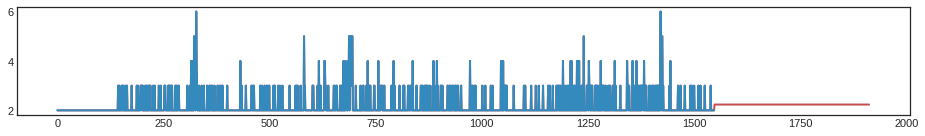

In [120]:
plt.figure(figsize=(16,2))

plt.plot(np.hstack((train[id_].to_numpy(), preds)), color='r')
plt.plot(train[id_].to_numpy())

plt.show()

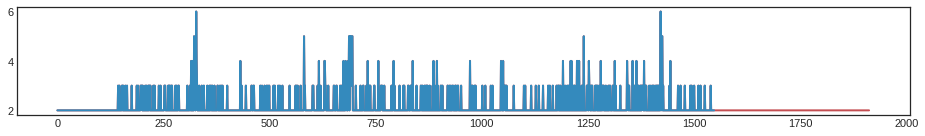

In [121]:
plt.figure(figsize=(16,2))

plt.plot(np.hstack((train[id_].to_numpy(), np.around(preds))), color='r')
plt.plot(train[id_].to_numpy())

plt.show()

####**Наивный прогноз.**

*Завтра = вчера.*

In [0]:
preds = train.iloc[-w_years:][id_].values

In [123]:
print('RMSE  - ', rmse(val[id_], preds))
print('MAPE  - ', mape(val[id_], preds))
print('RMSSE - ', rmsse(train[id_], val[id_], preds))

RMSE  -  0.8774183800779592
MAPE  -  13.334637964774949
RMSSE -  1.2518292310125896


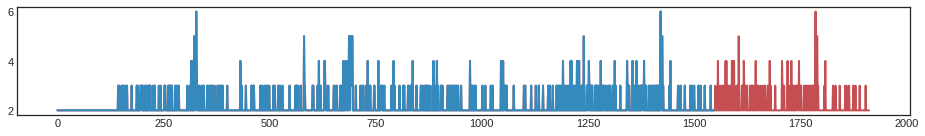

In [124]:
plt.figure(figsize=(16,2))

plt.plot(np.hstack((train[id_].to_numpy(), preds)), color='r')
plt.plot(train[id_].to_numpy())

plt.show()

Поинтересней, но очень часто "промазываем", т.к. много нулей.

####**Предсказание плавающим средним.**

*Новое значение будет вычисляться на основе среднего за конкретный 
период.*


In [0]:
#Оцениваем по последним N годам.
n = 4
tr_sample = train.iloc[-n*w_years:]
preds_arr = np.array(tr_sample[id_]).reshape(n,-1)

preds = preds_arr.mean(axis = 0)

In [126]:
print('RMSE  - ', rmse(val[id_], preds))
print('MAPE  - ', mape(val[id_], preds))
print('RMSSE - ', rmsse(train[id_], val[id_], preds))

RMSE  -  0.7418507031427716
MAPE  -  11.91340508806262
RMSSE -  1.0584122880567552


In [127]:
print('RMSE  - ', rmse(val[id_], np.around(preds)))
print('MAPE  - ', mape(val[id_], np.around(preds)))
print('RMSSE - ', rmsse(train[id_], val[id_], np.around(preds)))

RMSE  -  0.779884079900463
MAPE  -  9.20678408349641
RMSSE -  1.1126752187867484


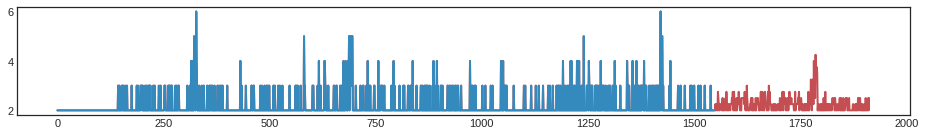

In [128]:
plt.figure(figsize=(16,2))

plt.plot(np.hstack((train[id_].to_numpy(), preds)), color='r')
plt.plot(train[id_].to_numpy())

plt.show()

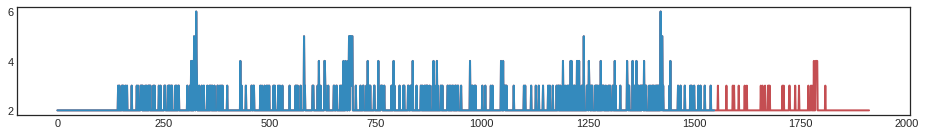

In [129]:
plt.figure(figsize=(16,2))

plt.plot(np.hstack((train[id_].to_numpy(), np.around(preds))), color='r')
plt.plot(train[id_].to_numpy())

plt.show()

*Опять хуже чем прогнозировать средним, все дело в нулях.*

####**Взвешенное среднее.**


In [0]:
W = np.array([0.1, 0.2, 0.3, 0.4])
preds_arr_W = np.array([preds_arr[x]*W[x] for x in range(len(W))])
preds = preds_arr_W.sum(axis = 0)

In [131]:
print('RMSE - ', rmse(val[id_], preds))
print('MAPE - ', mape(val[id_], preds))
print('RMSSE - ', rmsse(train[id_], val[id_], preds))

RMSE -  0.7515281235908243
MAPE -  12.184409654272669
RMSSE -  1.072219245003104


In [132]:
print('RMSE  - ', rmse(val[id_], np.around(preds)))
print('MAPE  - ', mape(val[id_], np.around(preds)))
print('RMSSE - ', rmsse(train[id_], val[id_], np.around(preds)))

RMSE  -  0.7851358838853205
MAPE  -  10.236464448793217
RMSSE -  1.1201680658629731


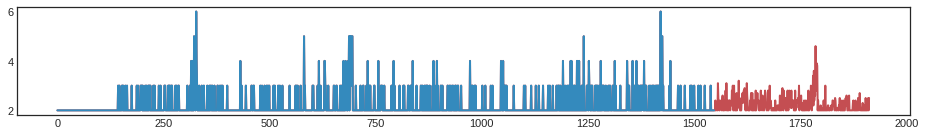

In [133]:
plt.figure(figsize=(16,2))

plt.plot(np.hstack((train[id_].to_numpy(), preds)), color='r')
plt.plot(train[id_].to_numpy())

plt.show()

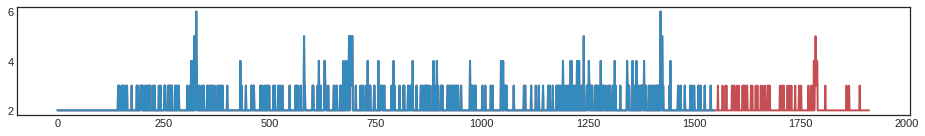

In [134]:
plt.figure(figsize=(16,2))

plt.plot(np.hstack((train[id_].to_numpy(), np.around(preds))), color='r')
plt.plot(train[id_].to_numpy())

plt.show()

####**Экспоненциальное сглаживание.**

In [0]:
model = SimpleExpSmoothing(train).fit(smoothing_level=0.7, optimized=False)
preds = model.forecast(val.shape[0])

In [136]:
print('RMSE - ', rmse(val[id_], preds))
print('MAPE - ', mape(val[id_], preds))
print('RMSSE - ', rmsse(train[id_], val[id_], preds))

RMSE -  0.7920636331212386
MAPE -  7.787512404992239
RMSSE -  1.1300520154080884


In [137]:
print('RMSE  - ', rmse(val[id_], np.around(preds)))
print('MAPE  - ', mape(val[id_], np.around(preds)))
print('RMSSE - ', rmsse(train[id_], val[id_], np.around(preds)))

RMSE  -  0.7920841244930822
MAPE  -  7.7866927592955
RMSSE -  1.1300812508319635


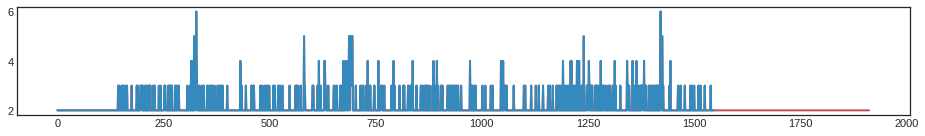

In [138]:
plt.figure(figsize=(16,2))

plt.plot(np.hstack((train[id_].to_numpy(), preds)), color='r')
plt.plot(train[id_].to_numpy())

plt.show()

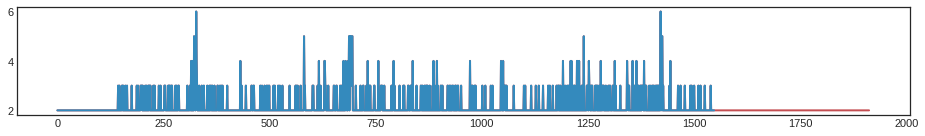

In [139]:
plt.figure(figsize=(16,2))

plt.plot(np.hstack((train[id_].to_numpy(), np.around(preds))), color='r')
plt.plot(train[id_].to_numpy())

plt.show()

*Из-за того, что у нас очень спарродические данные сглаживание просто обнуляет все.*

####**Двойное экспоненциальное сглаживание.**

In [0]:
model = Holt(train).fit(smoothing_level = 0.4, smoothing_slope = 0.2)
preds = model.forecast(val.shape[0])

In [141]:
print('RMSE - ', rmse(val[id_], preds))
print('MAPE - ', mape(val[id_], preds))
print('RMSSE - ', rmsse(train[id_], val[id_], preds))

RMSE -  3.7793790229161432
MAPE -  99.58957510336694
RMSSE -  5.392110814389211


In [142]:
print('RMSE  - ', rmse(val[id_], np.around(preds)))
print('MAPE  - ', mape(val[id_], np.around(preds)))
print('RMSSE - ', rmsse(train[id_], val[id_], np.around(preds)))

RMSE  -  3.8033870989760605
MAPE  -  99.57729941291585
RMSSE -  5.426363586013973


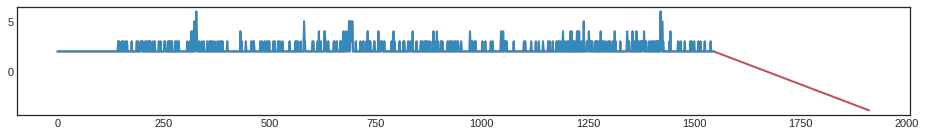

In [143]:
plt.figure(figsize=(16,2))

plt.plot(np.hstack((train[id_].to_numpy(), preds)), color='r')
plt.plot(train[id_].to_numpy())

plt.show()

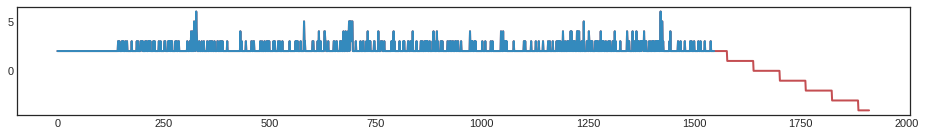

In [144]:
plt.figure(figsize=(16,2))

plt.plot(np.hstack((train[id_].to_numpy(), np.around(preds))), color='r')
plt.plot(train[id_].to_numpy())

plt.show()

*Ищим тренд там где его нет, не подходит совсем, при этом сглаживаем не нули и совсем не учитываем сезонность, что может быть вообще хуже?!*

*Попробуем наоброт, используем этот же подход, не будем учитывать тренд и наоборот учтем сезонность.*

####**Тройное экспоненциальное сглаживание.**

In [0]:
model = ExponentialSmoothing(train[id_],
                             seasonal_periods=365,
                             trend=None,
                             seasonal='add').fit()

preds = model.forecast(val.shape[0])
# forecast.index = val.index

In [146]:
print('RMSE - ', rmse(val[id_], preds))
print('MAPE - ', mape(val[id_], preds))
print('RMSSE - ', rmsse(train[id_], val[id_], preds))

RMSE -  0.745049671381715
MAPE -  11.750707613713187
RMSSE -  1.0629763159384535


In [147]:
print('RMSE  - ', rmse(val[id_], np.around(preds)))
print('MAPE  - ', mape(val[id_], np.around(preds)))
print('RMSSE - ', rmsse(train[id_], val[id_], np.around(preds)))

RMSE  -  0.7851358838853205
MAPE  -  9.081213307240704
RMSSE -  1.1201680658629731


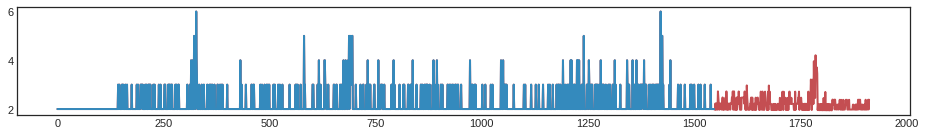

In [148]:
plt.figure(figsize=(16,2))

plt.plot(np.hstack((train[id_].to_numpy(), preds)), color='r')
plt.plot(train[id_].to_numpy())

plt.show()

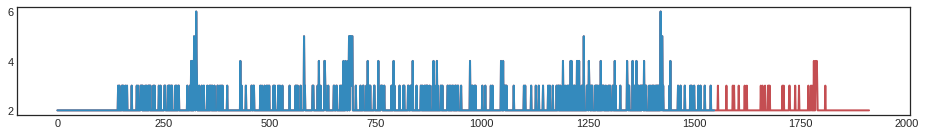

In [149]:
plt.figure(figsize=(16,2))

plt.plot(np.hstack((train[id_].to_numpy(), np.around(preds))), color='r')
plt.plot(train[id_].to_numpy())

plt.show()

*Как видим, отсутствие яркой сезонности, тренда и спородичность ряда приводит к тому, что классическая работа с времеными рядами тут не подходит, прогнозировать ряд, исходя только из его прошлых значений, некорректно в данной задаче, да и вообще особо бессмысленно как мы видим, поэтому в качестве самого простого **baseline**'а используем 3-ое экспоненциальное сглаживание, которое вероятнее всего будет себя в большинстве случаев просто как прогнозирование средним, а затем будем пробовать построение моделей использующие различные лаги, статистики и корреляции найденые нами выше и анализировать, и уже на основе этого делать прогноз с помощью **градиентного бустинга** и **рекурентной нейронной сети**.*

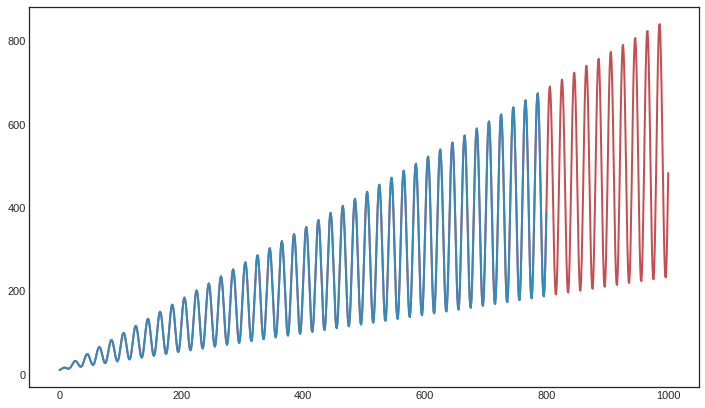

In [152]:
# Как должено было бы работать 3-ое эксп. сглаживание:

x = np.linspace(0,int(np.pi*100),1000)
data_ = x*np.sin(x)+x*1.7+10

tr_ = data_[:-200]
vl_ = data_[-200:]

pred = model = ExponentialSmoothing(tr_,
                                    seasonal_periods=20,
                                    trend='add',
                                    seasonal='mul').fit().forecast(200)

plt.plot(np.hstack((tr_,pred)), color='r')
plt.plot(tr_);

####**Дополнительно: попытка найти сезонность.**

In [153]:
id_ = '_1'
sample_data = date_df[id_]
sample_data = sample_data - sample_data.mean()
sample_data/= (sample_data.max() - sample_data.min())/2
sample_data

Datetime
2011-01-29   -0.103084
2011-01-30   -0.103084
2011-01-31   -0.103084
2011-02-01   -0.103084
2011-02-02   -0.103084
                ...   
2016-04-20    0.296916
2016-04-21   -0.103084
2016-04-22   -0.103084
2016-04-23   -0.103084
2016-04-24   -0.103084
Name: _1, Length: 1913, dtype: float64

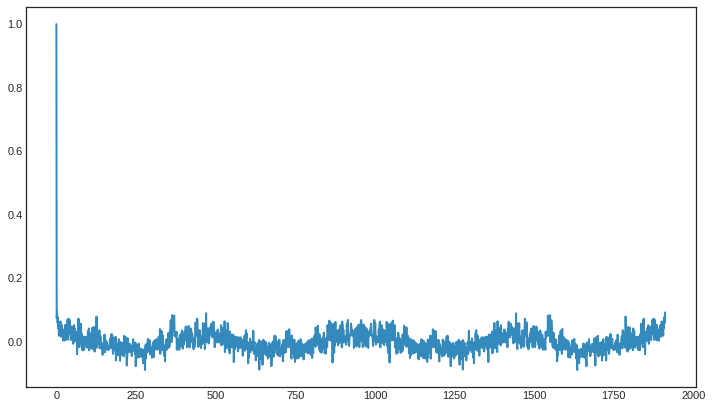

In [154]:
size_ = 1912
corr_history = []
for k in range(size_):  
    corr_history.append(stats.spearmanr(sample_data.values, np.roll(sample_data, k))[0])
plt.plot(corr_history);

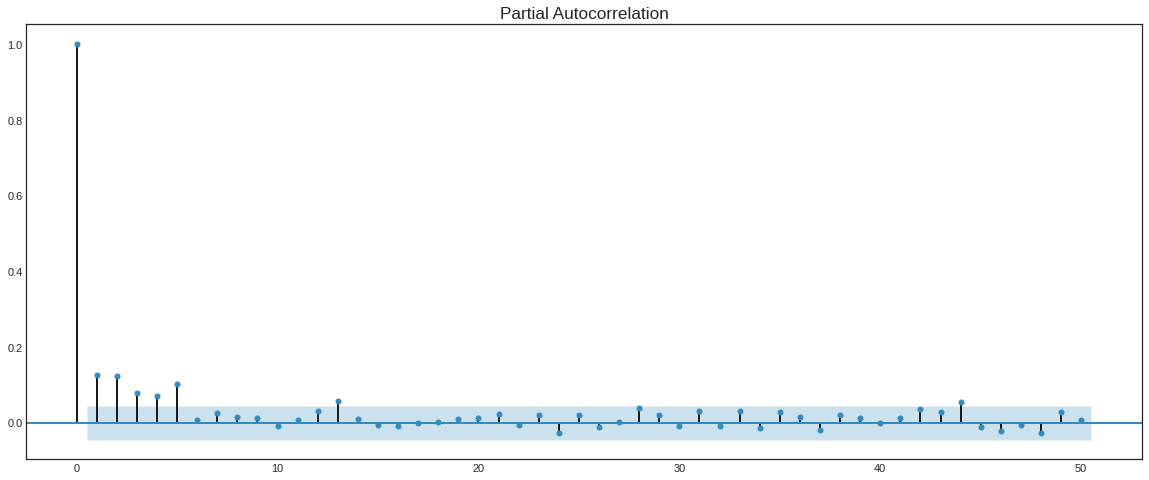

In [155]:
import statsmodels.api as sm
fig, ax = plt.subplots(figsize=(20,8))
sm.graphics.tsa.plot_pacf(sample_data.values, lags=50, ax = ax)
plt.show()

*Всё-таки удивительной корреляции нет, лишь малая линейная зависимости наблюдается периодом в 1 год (365), но если учесть что мы рассматривает частный пример, результатов не хватает для достаточного вывода.*

##**1. baseline - Экспоненциальное сглаживание.**

*Итак, мы опробовали несколько разных примитивных способов прогнозирования ряда, лучше всех оказалось, что стоит прогнозировать нулями, в этом действительно что-то есть, т.к. дело в том, что товары покупают достаточно редко, поэтому все выбокри достаточно разрежены и попытки прогнозировать не нулевые значения, приводят к тому, что мы угадываем в меньшей доле случаев, чем если бы все прогнозировали нулями.*

*Так же стоит ответить, что не всегда при округлении падала метрика RMSE и RMSSE, дело в том, что в них обеих происходить минимизация мат. ожидания, поэтому отклоняясь от среднего мы так или иначе результат сделаем хуже с точки зрения метрики, в MAPE, напротив, происходит взяция модуля, таким образом просиходит поиск медианы, поэтмому приведение к целым зачениям я становимся ближе к соответствующимуму оптимуму, с точки зрения MAPE.*

**Чтож, попробуем в этом шаге сделать конечный прогноз, при небольшой валидации, отправим наш результат на Kaggle, и сравним насколько результаты на нашей валидации будут близки к результатм на Kaggle, и начнем уже прогнозировать чем-то более мощным. На этом этапе испльзуем взвешенное среднее, поэксперементируем с сезонностью и типо модели (мультипликативной и аддитивной).**

In [156]:
# Если вдруг таблица на шагах выше испортилась, то сформируем её лишний раз.
date_df = main_df.drop(['event_type_1', 'snap_CA', 'snap_TX', 'snap_WI'], axis=1).reset_index()
date_df['Datetime'] = pd.to_datetime(date_df.date, format='%Y-%m-%d %H:%M:%S')
date_df.index  = date_df.Datetime
date_df.drop(['date', 'Datetime'], axis = 1, inplace = True)
date_df.head(2)

,_0,_1,_2,_3,_4,_5,_6,_7,_8,_9,_10,_11,_12,_13,_14,_15,_16,_17,_18,_19,_20,_21,_22,_23,_24,_25,_26,_27,_28,_29,_30,_31,_32,_33,_34,_35,_36,_37,_38,_39,...,_30450,_30451,_30452,_30453,_30454,_30455,_30456,_30457,_30458,_30459,_30460,_30461,_30462,_30463,_30464,_30465,_30466,_30467,_30468,_30469,_30470,_30471,_30472,_30473,_30474,_30475,_30476,_30477,_30478,_30479,_30480,_30481,_30482,_30483,_30484,_30485,_30486,_30487,_30488,_30489
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,9.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,16.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,14.0,0.0,0.0,7.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
2011-01-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,12.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.0,0.0,0.0,7.0,0.0,0.0,6.0,13.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,11.0,1.0,0.0,4.0,0.0,0.0,6.0,0.0,0.0


*Та валидационная схема, которая была у нас выше, конечно позволяет проверять наши результаты, но всё-таки нам хочется настроить максимально хорушую проверку, чтобы в идеале добиться того, чтобы результаты на наших тестах, были очень близки к результатам на тестах лежащими на Kaggle, так что давайте настроим что-нибудь мощнее, чем то, что было выше, т.е. кроссвалидацию (будет в 6.2).*

*Но перед там как валлидироваться, нужно описать все метрики, RMSE и MAPE будут дополнительно показывать качество работы модели, но конечный результат на Kaggle будет формирвоаться на основе **WRMSSE - взвешенного среднего RMSSE**, относительно цены на товар, продажы которого мы предсказываем, поэтому и ориентироваться будем на него. Напишем функцию, которая будет выдавать нам качество прогноза относительно **метрики WRMSSE** (будет в 6.2, пока обойдемся лишь средним RMSSE):*

In [0]:
from sklearn.model_selection import TimeSeriesSplit 

W = 7 # Лучше чем брать 2,30,60,180,365. Проверили циклом.

errors_rmse,   errors_mape,   errors_rmsse   = [], [], []
errors_rmse_r, errors_mape_r, errors_rmsse_r = [], [], []
    
tscv = TimeSeriesSplit(n_splits=6) 

for id_ in tqdm(list(id_dict.values())[::100]):

  error_rmse, error_mape, error_rmsse       = [], [], []
  error_rmse_r, error_mape_r, error_rmsse_r = [], [], []

  for train_idx, val_idx in tscv.split(date_df[id_]):

      train = date_df.loc[:,id_].iloc[train_idx]
      val   = date_df.loc[:,id_].iloc[val_idx]

      model = ExponentialSmoothing(train,
                                  seasonal_periods=W,
                                  trend = None,
                                  seasonal='add').fit()

      preds = model.forecast(val_idx.shape[0])

      error_rmse.append(rmse(val, preds))
      error_mape.append(mape(val, preds))
      error_rmsse.append(rmsse(train, val, preds))

      error_rmse_r.append(rmse(val, np.around(preds)))
      error_mape_r.append(mape(val, np.around(preds)))
      error_rmsse_r.append(rmsse(train, val, np.around(preds)))

  errors_rmse.append(np.mean(error_rmse))
  errors_mape.append(np.mean(error_mape))
  errors_rmsse.append(np.mean(sorted(error_rmse)[1:-1]))

  errors_rmse_r.append(np.mean(error_rmse_r))
  errors_mape_r.append(np.mean(error_mape_r))
  errors_rmsse_r.append(np.mean(sorted(error_rmse_r)[1:-1]))    
  

print('W: ', W)
print('RMSE  - %.4f' % np.mean(errors_rmse))
print('MAPE  - %.4f' % np.mean(errors_mape))
print('RMSSE - %.4f' % np.median(errors_rmsse), end='\n\n')

print('RMSE_R  - %.4f' % np.mean(errors_rmse_r))
print('MAPE_R  - %.4f' % np.mean(errors_mape_r))
print('RMSSE_R - %.4f' % np.median(errors_rmsse_r))


W:  7
RMSE  - 1.5180
MAPE  - 47.7303
RMSSE - 0.7888

RMSE_R  - 1.5455
MAPE_R  - 43.8217
RMSSE_R - 0.8345


*На этоп этапе подобрали, что в качестве сезонности лучше брать неделю т.е. 7 измерений, посчитали соответствующие метрики, настроили кроссвалидацию на 6 фолдах и проверили модель на 305 рядах, т.е. на каждом 100 товаре. Приступим непосредственно к написанию скриптов, которые будут формировать результат и отправим наш baseline на Kaggle, чтобы получить точный результат.*

In [0]:
W = 7
test_size = 28
cols = ['F'+str(i) for i in range(1,29)]
submission = pd.DataFrame([])

for id_ in tqdm(list(id_dict.values())):
    train = date_df.loc[:,id_]

    model = ExponentialSmoothing(train,
                                seasonal_periods=W,
                                trend = None,
                                seasonal='add').fit()

    preds = model.forecast(test_size)
    submission.loc[int(id_[1:]),cols] = preds.to_numpy()

*Циклом очень долго, ждать 24 минуты не преспективно, попытаемся ускорить, переписав на Numpy.*

In [0]:
def one_prediction(train):

  return ExponentialSmoothing(train,
                              seasonal_periods=W,
                              trend = None,
                              seasonal='add').fit().forecast(28)

In [160]:
%%time
all_pred = np.apply_along_axis(one_prediction, arr=date_df.to_numpy().T, axis=1)

CPU times: user 13min 8s, sys: 397 ms, total: 13min 9s
Wall time: 13min 9s


*Тоже долго, но хотя бы в 2 раза быстрее, скорей всего обучить 30490 моделей и сделать на каждую 28 предсказаний ускорить до нескольких минут, врядли получиться обычным Numpy.apply_along или vectorize.*

*Формируем результат для отправки на Kaggle.*

In [0]:
submission = pd.DataFrame(data=np.array(sol_data).reshape(28,30490)).T
submission = pd.concat((submission, submission), ignore_index=True)

sample_submission = pd.read_csv('/content/drive/My Drive/DAI_project/sample_submission.csv')        
submission[["id"]] = sample_submission[["id"]]

cols = list(submission.columns)
cols = cols[-1:] + cols[:-1]

submission = submission[cols]
submission.columns = ["id"] + [f"F{i}" for i in range (1,29)]
submission.to_csv("submission.csv", index=False)

In [0]:
submission.head(3)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.965509,1.957722,0.361462,0.312821,0.186088,0.058103,0.135425,0.166497,21.559174,0.040296,0.223958,4.349843,0.615686,0.491191,0.327252,0.441257,1.131425,0.235962,0.053620,0.032366,0.080590,0.115834,4.636329,0.332155,0.068563,3.967599,0.044547,0.445921
1,HOBBIES_1_002_CA_1_validation,1.030923,0.805834,0.453433,0.360312,0.098911,0.061725,0.117166,0.140890,22.920797,0.080577,0.147326,3.305935,0.745049,0.671212,0.301391,0.470275,1.296343,0.232164,-0.008421,0.028676,0.091583,0.086506,3.192343,0.372296,0.146994,3.503577,0.084931,0.264621
2,HOBBIES_1_003_CA_1_validation,0.920514,0.771043,0.782395,0.345436,0.091559,0.050739,0.168480,0.107956,17.359978,0.043792,0.246510,1.620927,0.777861,0.503243,0.341505,0.927151,1.437146,0.221039,0.009927,0.025014,0.106211,0.075493,1.468253,0.320746,0.031247,2.974649,0.103722,0.369037


***KAGGLE score: 3.88514***

***Место в лидерборде: 3240/3368 (ТОП <96.2%)***

*Чтож, главное не победа... как говорится.*

##**2. Полносвязная нейронная сеть, учитывающая лаговые статистики, различную информацию о товарах и т.п.**

In [0]:
import torch # Подключаем PyTorch - библиотеку для работы с нейронными сетями.

In [0]:
##**Рекурентный прогноз:**

In [0]:
log_step = 7 # Предполагаем, что сезонность имеет порядок в неделю.

class SATnet(torch.nn.Module):
  def __init__(self, n_hidden_neurons):
    super(SATnet, self).__init__()
    self.fc1  = torch.nn.Linear(log_step , n_hidden_neurons)
    self.act1 = torch.nn.ReLU()
    self.fc2  = torch.nn.Linear(n_hidden_neurons , n_hidden_neurons)
    self.act2 = torch.nn.ReLU()
    self.fc4  = torch.nn.Linear(n_hidden_neurons, 1)
    
  def forward(self, x):
    x = self.fc1(x)
    x = self.act1(x)
    x = self.fc2(x)
    x = self.act2(x)
    x = self.fc4(x)
    
    return x
  
SERIESnet = SATnet(50)

In [0]:
optimizer = torch.optim.Adam(SERIESnet.parameters(), lr=0.006)

def loss(pred, target):
  squares = (pred - target) ** 2
  return squares.mean()

In [0]:
# Функция для предикта test_size элементов.

def get_nn_predict(net, y_train, test_size):

  result = torch.Tensor([])
  prev_serie = y_train[-log_step:].T
  
  for _ in range(test_size):
    next_val = net.forward(prev_serie).data
    prev_serie = torch.cat((prev_serie[:,1:].T, next_val)).detach().T
    result = torch.cat((result, next_val))

  return result

In [0]:
# Прогноз сразу на сезон вперед, чтобы избежать увелечения ошибки на перспективе.

class SATnet(torch.nn.Module):
  def __init__(self, n_hidden_neurons):
    super(SATnet, self).__init__()
    self.fc1  = torch.nn.Linear(log_step , n_hidden_neurons)
    self.act1 = torch.nn.ReLU()
    self.fc2  = torch.nn.Linear(n_hidden_neurons , n_hidden_neurons)
    self.act2 = torch.nn.ReLU()
    self.fc3  = torch.nn.Linear(n_hidden_neurons , n_hidden_neurons)
    self.act3 = torch.nn.ReLU()
    self.fc4  = torch.nn.Linear(n_hidden_neurons , n_hidden_neurons)
    self.act4 = torch.nn.ReLU()
    self.fc5  = torch.nn.Linear(n_hidden_neurons , n_hidden_neurons)
    self.act5 = torch.nn.ReLU()
    self.fc6  = torch.nn.Linear(n_hidden_neurons , n_hidden_neurons)
    self.act6 = torch.nn.ReLU()
    self.fc7  = torch.nn.Linear(n_hidden_neurons , n_hidden_neurons)
    self.act7 = torch.nn.ReLU()
    self.fc8  = torch.nn.Linear(n_hidden_neurons, log_step)
    
  def forward(self, x):
    x = self.fc1(x)
    x = self.act1(x)
    x = self.fc2(x)
    x = self.act2(x)
    x = self.fc3(x)
    x = self.act3(x)
    x = self.fc4(x)
    x = self.act4(x)
    x = self.fc5(x)
    x = self.act5(x)
    x = self.fc6(x)
    x = self.act6(x)
    x = self.fc7(x)
    x = self.act7(x)
    x = self.fc8(x)
    
    return x
  
SERIESnet = SATnet(50)

In [0]:
# Функция для тренировки нейронной сети.

def train_NN(SERIESnet, X_train, y_train, N_number):

  min_smape = 201
  SERIESnet = SATnet(N_number)
  optimizer = torch.optim.Adam(SERIESnet.parameters(), lr=0.01)
  flag = True
  i=0
  k=0
  while i < 300:
    
    i+=1
    k+=1

    optimizer.zero_grad()
    
    y_pred = SERIESnet.forward(X_train)
    loss_test = loss(y_pred, y_train)
    loss_test.backward()
    
    optimizer.step()

    y_test_pred = get_nn_predict(SERIESnet, X_val, y_val.shape[0])
    cur_smape = smape(y_test_pred, y_val)

    if cur_smape < min_smape:
      min_smape = cur_smape
      best_SERIESnet = SERIESnet

    if cur_smape < 15 and flag:
      optimizer = torch.optim.Adam(SERIESnet.parameters(), lr=0.007)
      flag = False
      
    if cur_smape < 3.5:
      break

    if i > 250 and cur_smape > 15:
      i = 0
      SERIESnet = SATnet(N_number)
      optimizer = torch.optim.Adam(SERIESnet.parameters(), lr=0.01)          

    if k > 2000:
      break

  return best_SERIESnet

In [0]:
# Пока на этом остановимся, в перспективе реализовать прогноз временного ряда, операясь на множество лаговых статистик
#  значения парных корреляция и т.п. Использовать LSTM - рекурентную сеть с памятью.